In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import os


In [2]:
CUBLAS_NAME = "cuBLAS"
algo_map = {
    2: CUBLAS_NAME,
    3: "cuSPARSE",
    7: "MACKO",
}

In [3]:
dasp_results_base = "../../DASP/dasp_results_16bit"
sputnik_results_base = "../../SpInfer/kernel_benchmark/sputnik_results_16bit"

In [4]:
def load_results(gpu_name, bits=16):
    path = f"../c_benchmarking/results_{bits}bit/{gpu_name}/results.txt"
    df = pd.read_csv(path, sep="\t", skiprows=1, index_col=None, names=["","Bits per value", "Rows", "Cols", "Algorithm", "Density", "Runtime", "GFLOPS", "Sparse GFLOPS"])
    df.loc[df["Runtime"]==" ", "Runtime"] = None
    df["Runtime"] = df["Runtime"].astype(float)
    df["Algorithm"] = df["Algorithm"].map(algo_map)

    dasp_path = os.path.join(dasp_results_base, gpu_name, "results.txt")
    if os.path.exists(dasp_path):
        dasp_df = pd.read_csv(
            dasp_path, sep="\t",
            skiprows=1, index_col=None, names=["","Bits per value", "Rows", "Cols", "Algorithm", "Density", "Runtime", "GFLOPS", "Sparse GFLOPS"])
        df = pd.concat([df, dasp_df]).reset_index()

    sputnik_path = os.path.join(sputnik_results_base, gpu_name, "sputnik_performance_results.csv")
    if os.path.exists(sputnik_path):
        sputnik_df_raw = pd.read_csv(sputnik_path)
        sputnik_df = pd.DataFrame({
            "Bits per value":16, 
            "Rows":sputnik_df_raw["M"],
            "Cols":sputnik_df_raw["K"],
            "Algorithm":sputnik_df_raw["Kernel"],
            "Density": (100-sputnik_df_raw["Sparsity"])/100,
            "Runtime": (sputnik_df_raw["Duration(ns)"]/1000).round(),
            "GFLOPS": (2*sputnik_df_raw["M"]*sputnik_df_raw["K"])/sputnik_df_raw["Duration(ns)"],
        })
        sputnik_df["GFLOPS"] = (sputnik_df["Rows"]*sputnik_df["Cols"])/(sputnik_df["Runtime"]*1000)
        sputnik_df["Sparse GFLOPS"] = (2*sputnik_df["Rows"]*sputnik_df["Cols"]*sputnik_df["Density"])/(sputnik_df["Runtime"]*1000)
        df = pd.concat([df, sputnik_df]).reset_index()

    df = df[df["Algorithm"]!="DASP2"]
    df = df[df["Algorithm"]!="DASPcuSPARSE"]

    return df


In [5]:
paper_path = "../../macko_spmv_paper"

In [6]:
def draw_speedup(full_df, gpu_name, size, to_paper=False):
    gpu_name_nice = gpu_name.replace("_", " ")

    R, C = size
    df = full_df[full_df['Algorithm'].isin([CUBLAS_NAME, "MACKO", "cuSPARSE", "Sputnik"])]

    for_m = df.query(f"Rows=={R} and Cols=={C}").copy()
    cublas_runtimes = for_m.query(f"Algorithm=='{CUBLAS_NAME}'")[["Runtime", "Density"]]
    cublas_runtime = cublas_runtimes["Runtime"].mean()
    for_m = pd.merge(for_m, cublas_runtimes, how="left", on="Density", suffixes=("","_cublas"))
    for_m["Speedup over cuBLAS"] = for_m["Runtime_cublas"]/for_m["Runtime"]
    for_m["Sparsity"] = (1-for_m["Density"]).round(2)
    for_m["Density"] = for_m["Density"]

    ax = sns.lineplot(data=for_m, x="Sparsity", y="Speedup over cuBLAS", hue="Algorithm")

    cublas_color = [line.get_color() for line in ax.lines if line.get_label().strip() == CUBLAS_NAME][0]

    for line in ax.lines:
        # Get the data of this line
        x_data = line.get_xdata()
        y_data = line.get_ydata()
        if line.get_color() == cublas_color:
            continue
        
        for x, y in zip(x_data, y_data):
            ax.text(
                x, y,
                f'{y:.2f}',          # format label
                color="black",
                fontsize=9,
                ha='center',         # horizontal alignment
                va='bottom'          # vertical alignment
            )

    plt.xticks([0.1*x for x in range(11)])
    plt.grid(linestyle=":", alpha=0.5)
    title = f"{gpu_name_nice}, fp16, {R}x{C}, cuBLAS runtime {int(cublas_runtime)} $\\mu s$"

    if not to_paper:
        plt.title(title)
    print(title)
    if to_paper:
        plt.savefig(os.path.join(paper_path, f"paper/fp16_{gpu_name}_{R}_{C}_relative_speedup.pdf"))
    else:
        plt.savefig(f"../media/fp16_{gpu_name}_{R}_{C}_relative_speedup.svg")
        plt.savefig(f"../media/fp16_{gpu_name}_{R}_{C}_relative_speedup.png")

    plt.show()

In [24]:
def draw_speedup_bar(full_df, gpu_name, size, to_paper=False):
    gpu_name_nice = gpu_name.replace("_", " ")

    R, C = size
    df = full_df[full_df['Algorithm'].isin([CUBLAS_NAME, "MACKO", "cuSPARSE", "Sputnik", "DASP"])]

    for_m = df.query(f"Rows=={R} and Cols=={C}").copy()
    cublas_runtimes = for_m.query(f"Algorithm=='{CUBLAS_NAME}'")[["Runtime", "Density"]]
    cublas_runtime = cublas_runtimes["Runtime"].mean()
    for_m = pd.merge(for_m, cublas_runtimes, how="left", on="Density", suffixes=("","_cublas"))
    for_m["Speedup over cuBLAS"] = for_m["Runtime_cublas"]/for_m["Runtime"]
    for_m["Sparsity"] = (1-for_m["Density"]).round(2).apply(lambda x: f"{int(x*100)}%")
    for_m["Density"] = for_m["Density"]

    plt.figure(figsize=(12,4))
    ax = sns.barplot(data=for_m, x="Sparsity", y="Speedup over cuBLAS", hue="Algorithm")

    for container in ax.containers:
        ax.bar_label(container, fmt='  %.2f', label_type='edge', rotation=90, fontsize=8)

    plt.ylim(0, for_m["Speedup over cuBLAS"].max()+1.0)
    plt.grid(linestyle=":", alpha=0.5)
    title = f"{gpu_name_nice}, fp16, {R}x{C}, cuBLAS runtime {int(cublas_runtime)} $\\mu s$"

    if not to_paper:
        plt.title(title)
    print(title)
    if to_paper:
        plt.savefig(os.path.join(paper_path, f"paper/fp16_{gpu_name}_{R}_{C}_relative_speedup.pdf"))
    else:
        plt.savefig(f"../media/fp16_{gpu_name}_{R}_{C}_relative_speedup_bar.svg")
        #plt.savefig(f"../media/fp16_{gpu_name}_{R}_{C}_relative_speedup_bar.png")

    plt.show()


In [25]:
def draw_speedup_over_all_sizes(df, gpu_name, to_paper=False):
    gpu_name_nice = gpu_name.replace("_", " ")

    over_sizes = df.copy()
    speedups = []
    for i, row in over_sizes.iterrows():
        cublas_runtime = df.query(f"Rows=={row.Rows} and Cols=={row.Cols} and Density=={row.Density} and Algorithm=='{CUBLAS_NAME}'")["Runtime"].mean()
        speedup = cublas_runtime/row.Runtime
        speedups.append(speedup)


    over_sizes["Sparsity"] = (1-over_sizes["Density"]).round(2).apply(lambda x: f"{int(100*x)}%")
    over_sizes["Speedup over cuBLAS"] = speedups
    sns.boxplot(data=over_sizes, x="Sparsity", y="Speedup over cuBLAS", hue="Algorithm", fill=False, gap=.1)

    plt.grid(linestyle=":", alpha=0.5)

    title = f"{gpu_name_nice}, fp16"
    print(title)
    if not to_paper:
        plt.title(title)

    if to_paper:
        plt.savefig(os.path.join(paper_path, f"paper/{gpu_name}_relative_speedup_all_sizes.pdf"))
    else:
        plt.savefig(f"../media/{gpu_name}_relative_speedup_all_sizes.svg")
        #plt.savefig(f"../media/{gpu_name}_relative_speedup_all_sizes.png")

    plt.show()

    for d in ["0.1", "0.5"]:
        df_d = over_sizes.query(f"Algorithm == 'MACKO' and Density=={d}")
        print(f"Density {d}")
        display(df_d[["Rows", "Cols", "Speedup over cuBLAS"]].describe())


NVIDIA GeForce RTX 4090, fp16


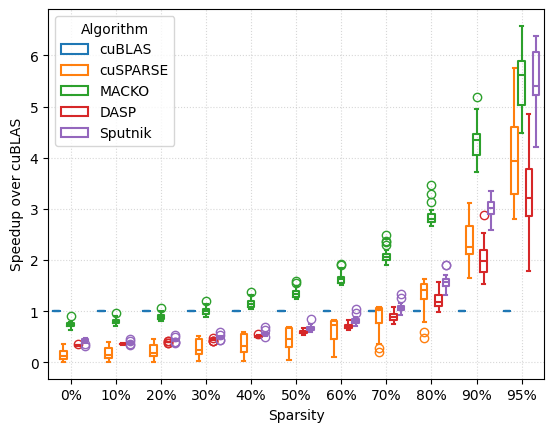

Density 0.1


Rows          Cols  Speedup over cuBLAS
count     31.000000     31.000000            31.000000
mean   16631.741935  12936.258065             4.307942
std    12519.679738  11009.633887             0.302822
min     3584.000000   3584.000000             3.727273
25%     7168.000000   5120.000000             4.053559
50%    12288.000000   9216.000000             4.339806
75%    28160.000000  14080.000000             4.457801
max    49152.000000  49152.000000             5.187500

Density 0.5


Rows          Cols  Speedup over cuBLAS
count     31.000000     31.000000            31.000000
mean   16631.741935  12936.258065             1.353817
std    12519.679738  11009.633887             0.090849
min     3584.000000   3584.000000             1.231707
25%     7168.000000   5120.000000             1.286889
50%    12288.000000   9216.000000             1.333333
75%    28160.000000  14080.000000             1.389436
max    49152.000000  49152.000000             1.594595

NVIDIA GeForce RTX 3090, fp16


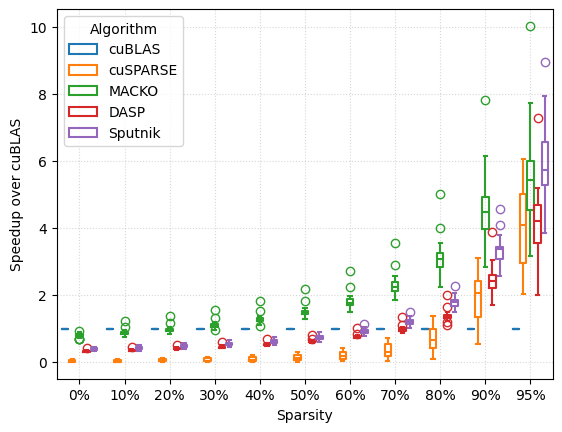

Density 0.1


Rows          Cols  Speedup over cuBLAS
count     31.000000     31.000000            31.000000
mean   16631.741935  12936.258065             4.509329
std    12519.679738  11009.633887             0.922362
min     3584.000000   3584.000000             2.842105
25%     7168.000000   5120.000000             3.958546
50%    12288.000000   9216.000000             4.472000
75%    28160.000000  14080.000000             4.933966
max    49152.000000  49152.000000             7.814961

Density 0.5


Rows          Cols  Speedup over cuBLAS
count     31.000000     31.000000            31.000000
mean   16631.741935  12936.258065             1.490779
std    12519.679738  11009.633887             0.166093
min     3584.000000   3584.000000             1.295455
25%     7168.000000   5120.000000             1.430252
50%    12288.000000   9216.000000             1.477273
75%    28160.000000  14080.000000             1.537600
max    49152.000000  49152.000000             2.176535

NVIDIA GeForce RTX 2080 SUPER, fp16


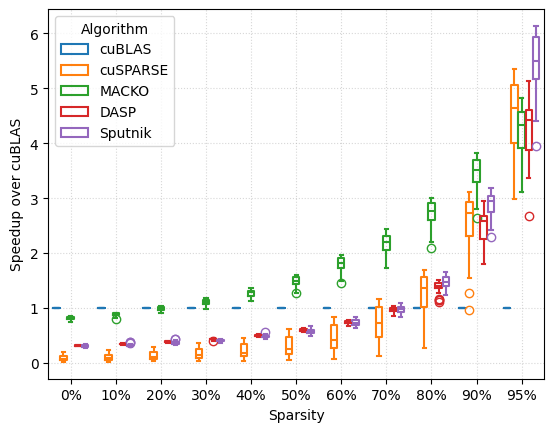

Density 0.1


Rows          Cols  Speedup over cuBLAS
count     31.000000     31.000000            31.000000
mean   16631.741935  12936.258065             3.437532
std    12519.679738  11009.633887             0.300251
min     3584.000000   3584.000000             2.636364
25%     7168.000000   5120.000000             3.289617
50%    12288.000000   9216.000000             3.506849
75%    28160.000000  14080.000000             3.693647
max    49152.000000  49152.000000             3.823383

Density 0.5


Rows          Cols  Speedup over cuBLAS
count     31.000000     31.000000            31.000000
mean   16631.741935  12936.258065             1.480932
std    12519.679738  11009.633887             0.096345
min     3584.000000   3584.000000             1.264706
25%     7168.000000   5120.000000             1.441654
50%    12288.000000   9216.000000             1.494118
75%    28160.000000  14080.000000             1.554791
max    49152.000000  49152.000000             1.601810

In [26]:
for target_gpu in ["NVIDIA_GeForce_RTX_4090", "NVIDIA_GeForce_RTX_3090", "NVIDIA_GeForce_RTX_2080_SUPER"]:
    df = load_results(target_gpu)
    draw_speedup_over_all_sizes(df, target_gpu, to_paper=True)

NVIDIA GeForce RTX 4090, fp16


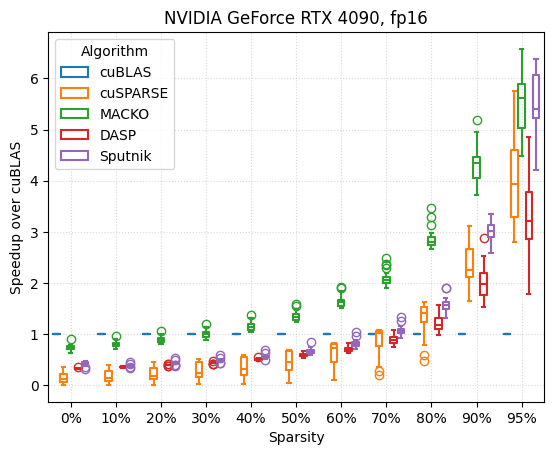

Density 0.1


Rows          Cols  Speedup over cuBLAS
count     31.000000     31.000000            31.000000
mean   16631.741935  12936.258065             4.307942
std    12519.679738  11009.633887             0.302822
min     3584.000000   3584.000000             3.727273
25%     7168.000000   5120.000000             4.053559
50%    12288.000000   9216.000000             4.339806
75%    28160.000000  14080.000000             4.457801
max    49152.000000  49152.000000             5.187500

Density 0.5


Rows          Cols  Speedup over cuBLAS
count     31.000000     31.000000            31.000000
mean   16631.741935  12936.258065             1.353817
std    12519.679738  11009.633887             0.090849
min     3584.000000   3584.000000             1.231707
25%     7168.000000   5120.000000             1.286889
50%    12288.000000   9216.000000             1.333333
75%    28160.000000  14080.000000             1.389436
max    49152.000000  49152.000000             1.594595

NVIDIA GeForce RTX 3090, fp16


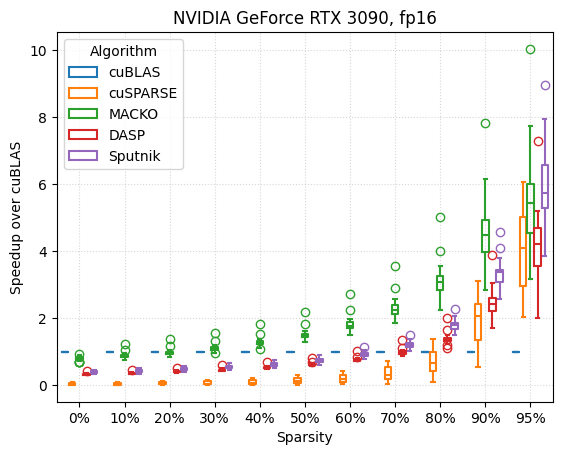

Density 0.1


Rows          Cols  Speedup over cuBLAS
count     31.000000     31.000000            31.000000
mean   16631.741935  12936.258065             4.509329
std    12519.679738  11009.633887             0.922362
min     3584.000000   3584.000000             2.842105
25%     7168.000000   5120.000000             3.958546
50%    12288.000000   9216.000000             4.472000
75%    28160.000000  14080.000000             4.933966
max    49152.000000  49152.000000             7.814961

Density 0.5


Rows          Cols  Speedup over cuBLAS
count     31.000000     31.000000            31.000000
mean   16631.741935  12936.258065             1.490779
std    12519.679738  11009.633887             0.166093
min     3584.000000   3584.000000             1.295455
25%     7168.000000   5120.000000             1.430252
50%    12288.000000   9216.000000             1.477273
75%    28160.000000  14080.000000             1.537600
max    49152.000000  49152.000000             2.176535

NVIDIA GeForce RTX 2080 SUPER, fp16


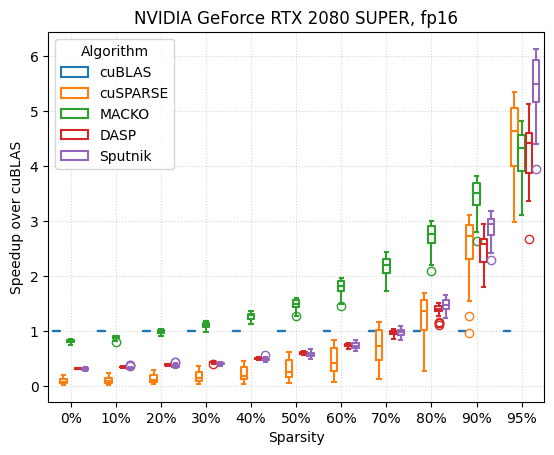

Density 0.1


Rows          Cols  Speedup over cuBLAS
count     31.000000     31.000000            31.000000
mean   16631.741935  12936.258065             3.437532
std    12519.679738  11009.633887             0.300251
min     3584.000000   3584.000000             2.636364
25%     7168.000000   5120.000000             3.289617
50%    12288.000000   9216.000000             3.506849
75%    28160.000000  14080.000000             3.693647
max    49152.000000  49152.000000             3.823383

Density 0.5


Rows          Cols  Speedup over cuBLAS
count     31.000000     31.000000            31.000000
mean   16631.741935  12936.258065             1.480932
std    12519.679738  11009.633887             0.096345
min     3584.000000   3584.000000             1.264706
25%     7168.000000   5120.000000             1.441654
50%    12288.000000   9216.000000             1.494118
75%    28160.000000  14080.000000             1.554791
max    49152.000000  49152.000000             1.601810

In [27]:
for target_gpu in ["NVIDIA_GeForce_RTX_4090", "NVIDIA_GeForce_RTX_3090", "NVIDIA_GeForce_RTX_2080_SUPER"]:
    df = load_results(target_gpu)
    draw_speedup_over_all_sizes(df, target_gpu)

In [28]:
shapes = [
    [4096,4096],
    [8192,8192],
    [8192,29568],
    [32000,5120],
    [32000,8192],
    [28672,8192],
    [5120,5120],
    [5120,13824],
    [3584,20480],
    [4096,11008],
    [13824,5120],
    [18944,3584],
    [14336,4096],
    [4096,14336],
    [8192,28672],
    [11008,4096],
    [32000,4096],
    [20480,3584],
    [3584,18944],
    [21504,7168],
    [7168,7168],
    [28672,7168],
    [7168,28672],
    [27648,9216],
    [9216,9216],
    [36864,9216],
    [9216,36864],
    [36864,12288],
    [12288,12288],
    [49152,12288],
    [12288,49152],
]
gpus = ["NVIDIA_GeForce_RTX_4090", "NVIDIA_GeForce_RTX_3090", "NVIDIA_GeForce_RTX_2080_SUPER"]


NVIDIA GeForce RTX 4090, fp16, 4096x4096, cuBLAS runtime 59 $\mu s$


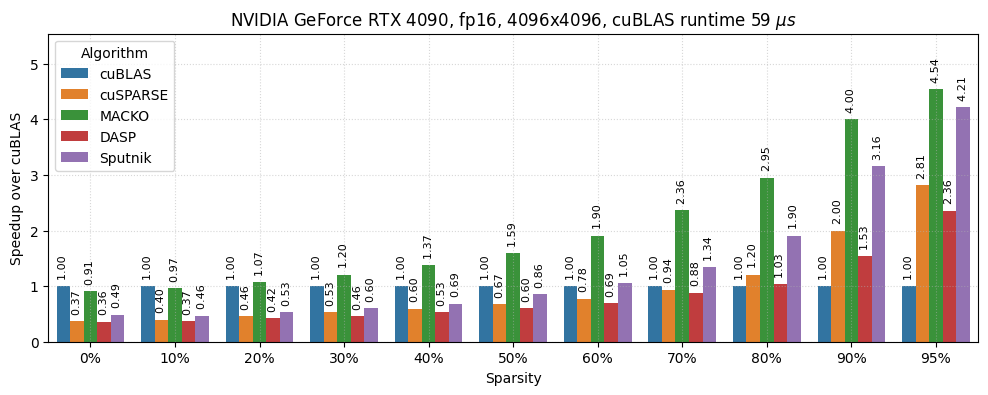

NVIDIA GeForce RTX 4090, fp16, 8192x8192, cuBLAS runtime 166 $\mu s$


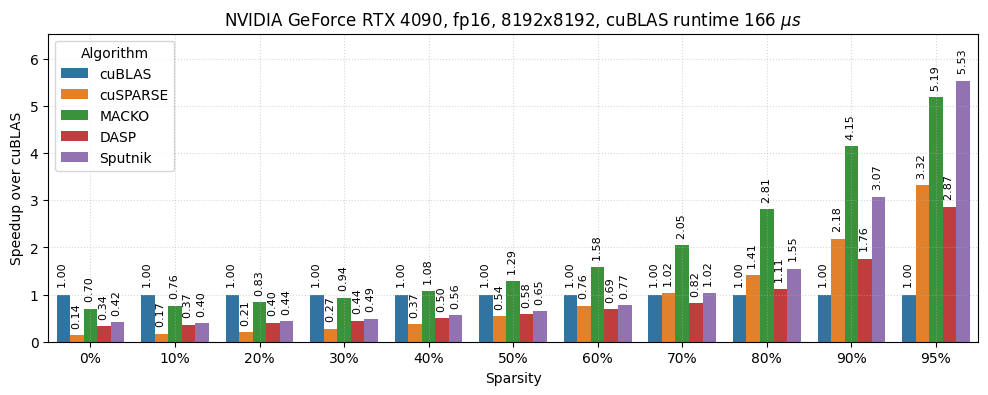

NVIDIA GeForce RTX 4090, fp16, 8192x29568, cuBLAS runtime 523 $\mu s$


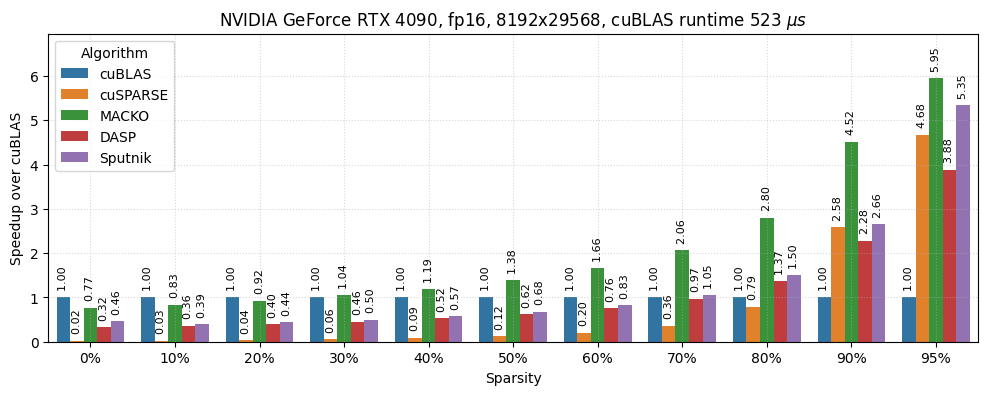

NVIDIA GeForce RTX 4090, fp16, 32000x5120, cuBLAS runtime 362 $\mu s$


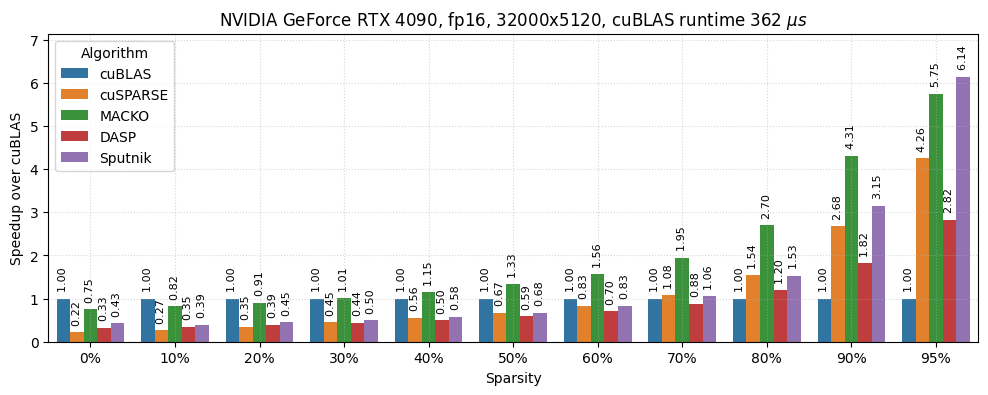

NVIDIA GeForce RTX 4090, fp16, 32000x8192, cuBLAS runtime 562 $\mu s$


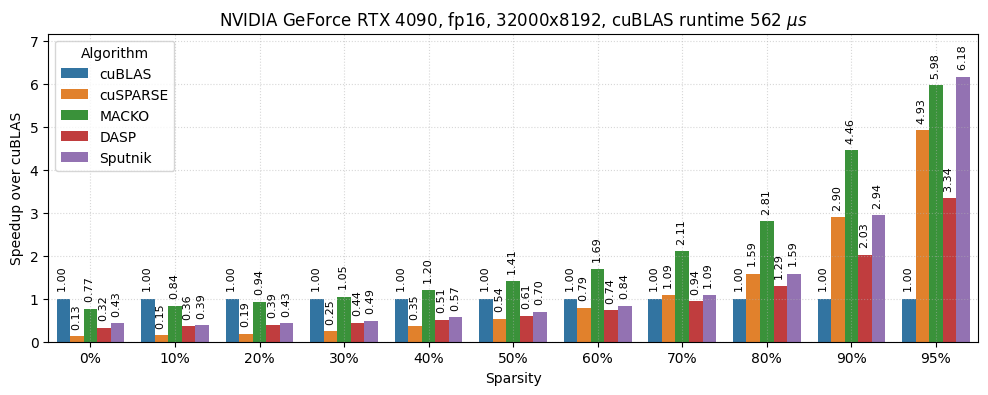

NVIDIA GeForce RTX 4090, fp16, 28672x8192, cuBLAS runtime 507 $\mu s$


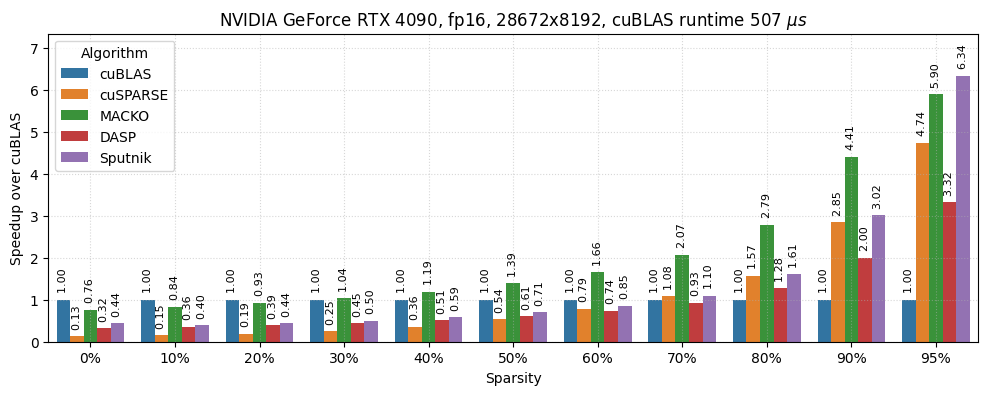

NVIDIA GeForce RTX 4090, fp16, 5120x5120, cuBLAS runtime 82 $\mu s$


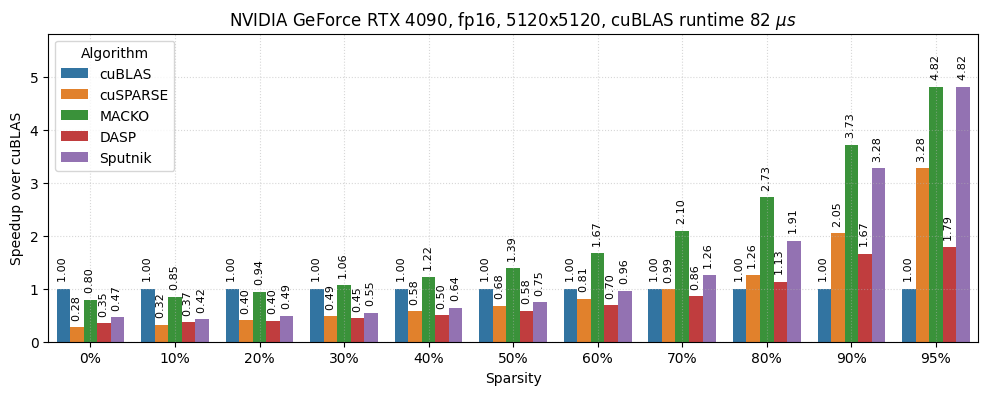

NVIDIA GeForce RTX 4090, fp16, 5120x13824, cuBLAS runtime 174 $\mu s$


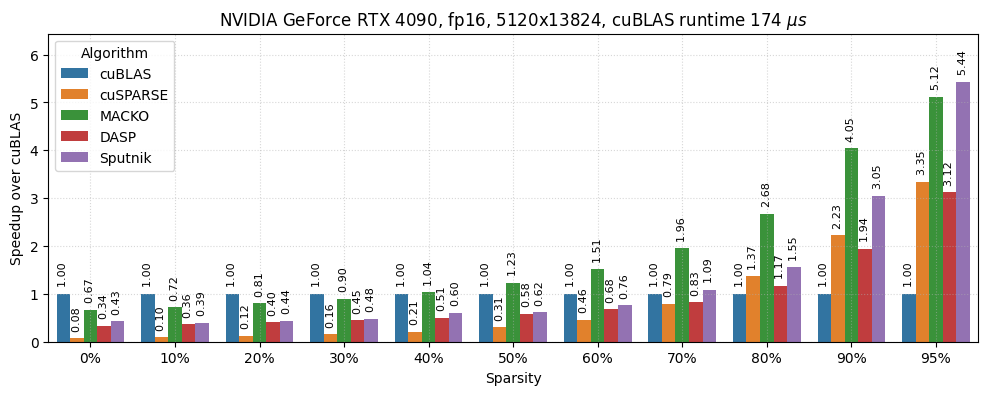

NVIDIA GeForce RTX 4090, fp16, 3584x20480, cuBLAS runtime 179 $\mu s$


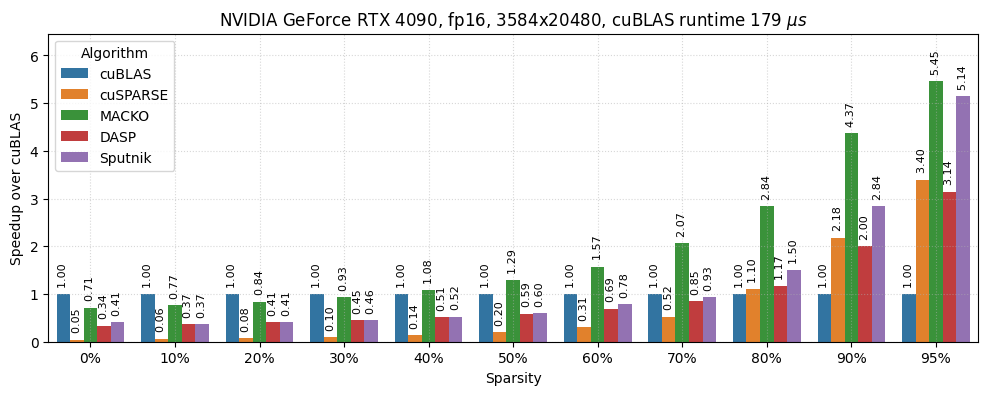

NVIDIA GeForce RTX 4090, fp16, 4096x11008, cuBLAS runtime 122 $\mu s$


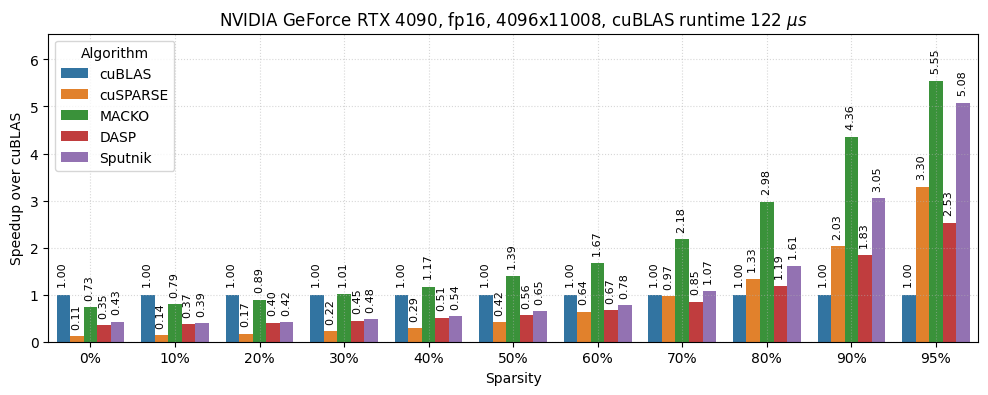

NVIDIA GeForce RTX 4090, fp16, 13824x5120, cuBLAS runtime 173 $\mu s$


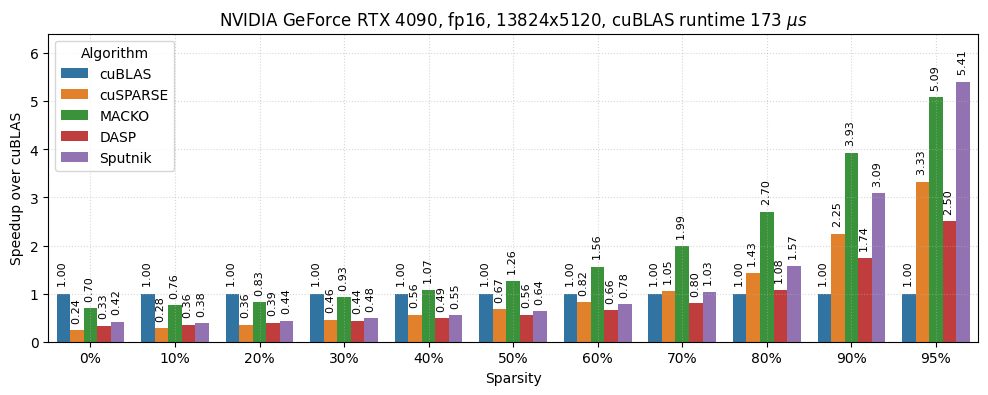

NVIDIA GeForce RTX 4090, fp16, 18944x3584, cuBLAS runtime 166 $\mu s$


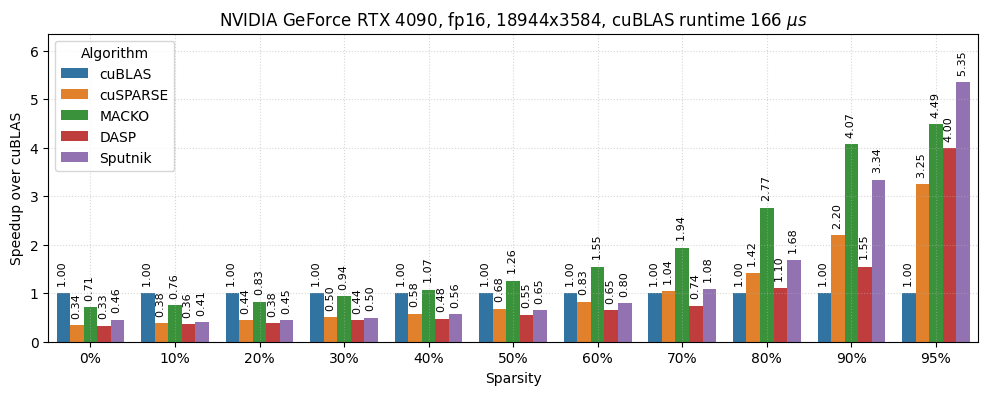

NVIDIA GeForce RTX 4090, fp16, 14336x4096, cuBLAS runtime 148 $\mu s$


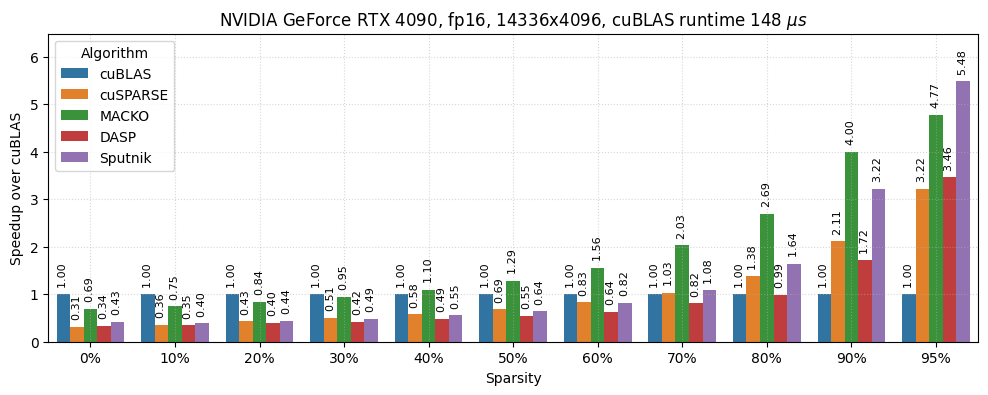

NVIDIA GeForce RTX 4090, fp16, 4096x14336, cuBLAS runtime 149 $\mu s$


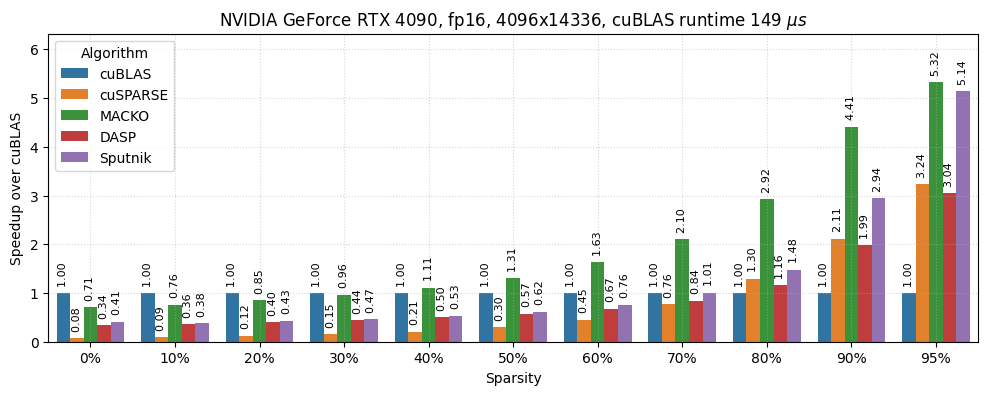

NVIDIA GeForce RTX 4090, fp16, 8192x28672, cuBLAS runtime 508 $\mu s$


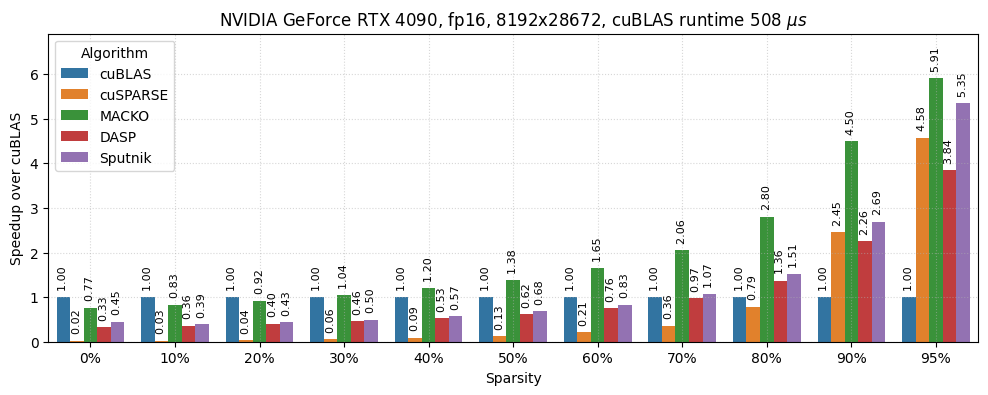

NVIDIA GeForce RTX 4090, fp16, 11008x4096, cuBLAS runtime 120 $\mu s$


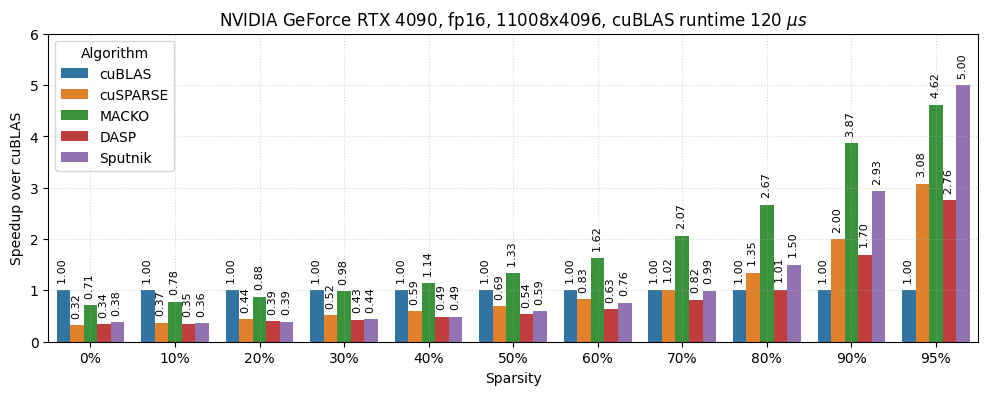

NVIDIA GeForce RTX 4090, fp16, 32000x4096, cuBLAS runtime 295 $\mu s$


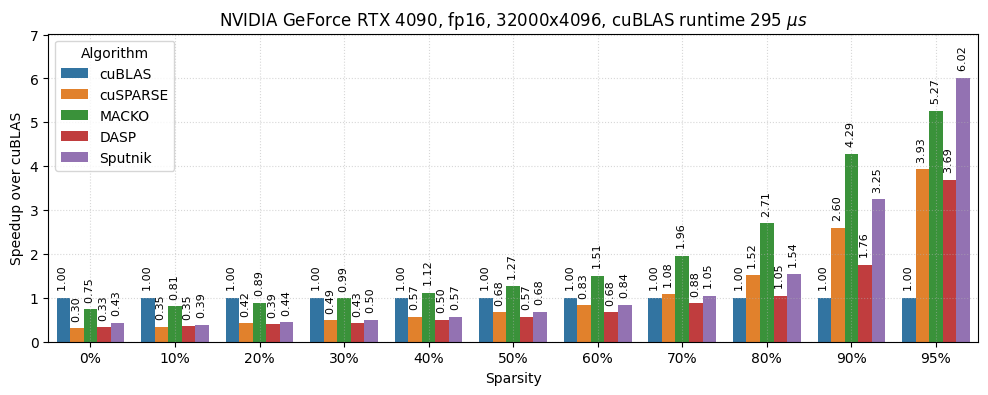

NVIDIA GeForce RTX 4090, fp16, 20480x3584, cuBLAS runtime 178 $\mu s$


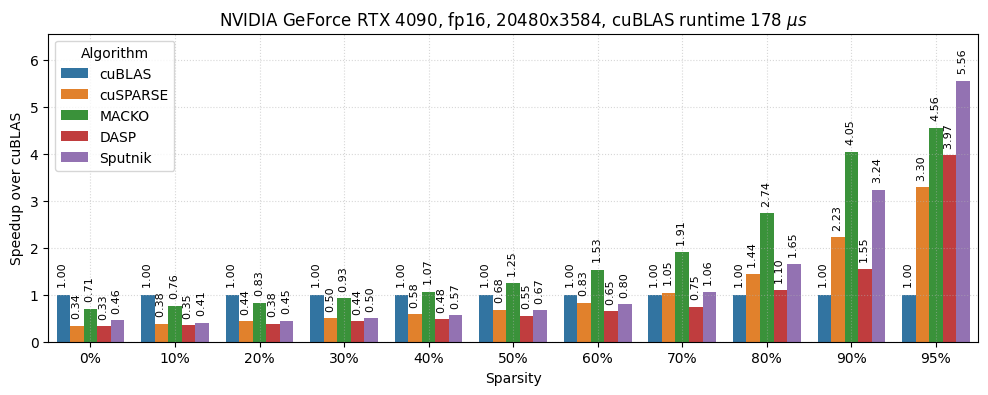

NVIDIA GeForce RTX 4090, fp16, 3584x18944, cuBLAS runtime 168 $\mu s$


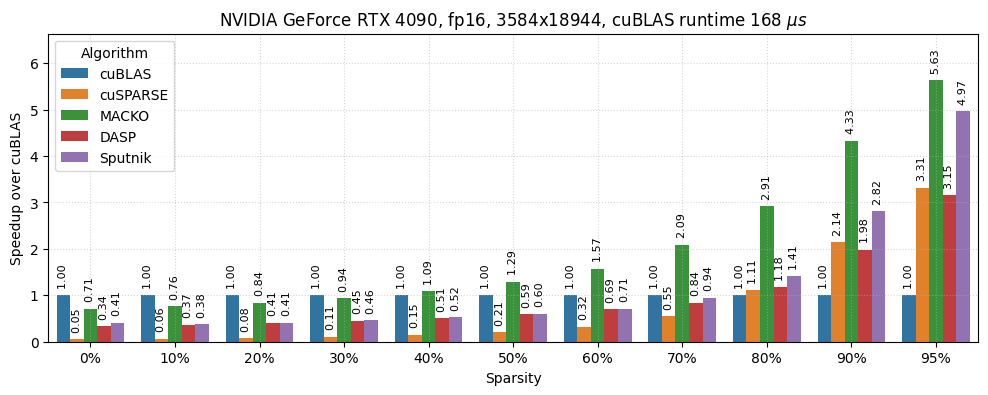

NVIDIA GeForce RTX 4090, fp16, 21504x7168, cuBLAS runtime 343 $\mu s$


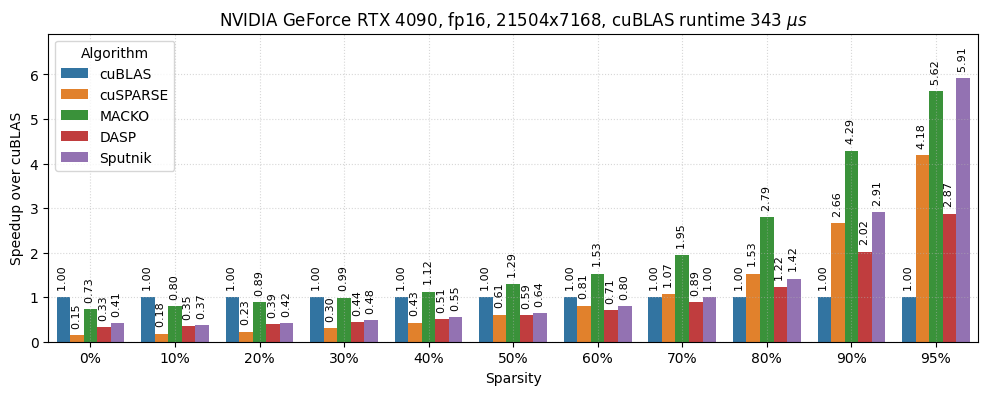

NVIDIA GeForce RTX 4090, fp16, 7168x7168, cuBLAS runtime 134 $\mu s$


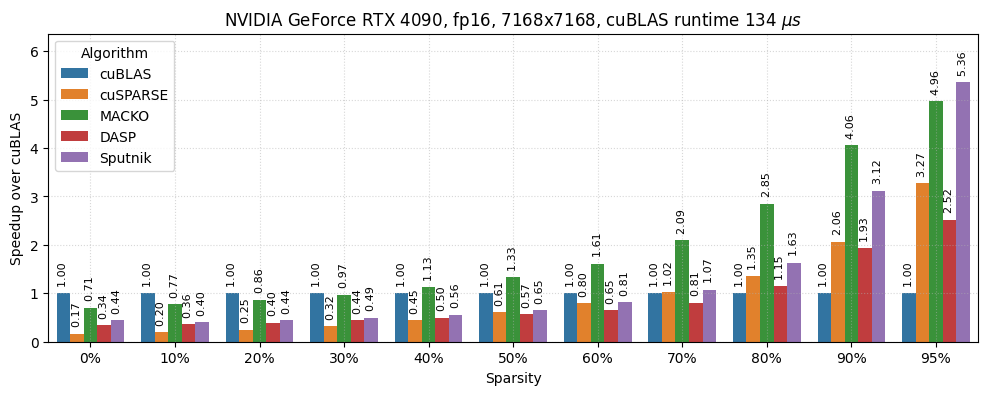

NVIDIA GeForce RTX 4090, fp16, 28672x7168, cuBLAS runtime 447 $\mu s$


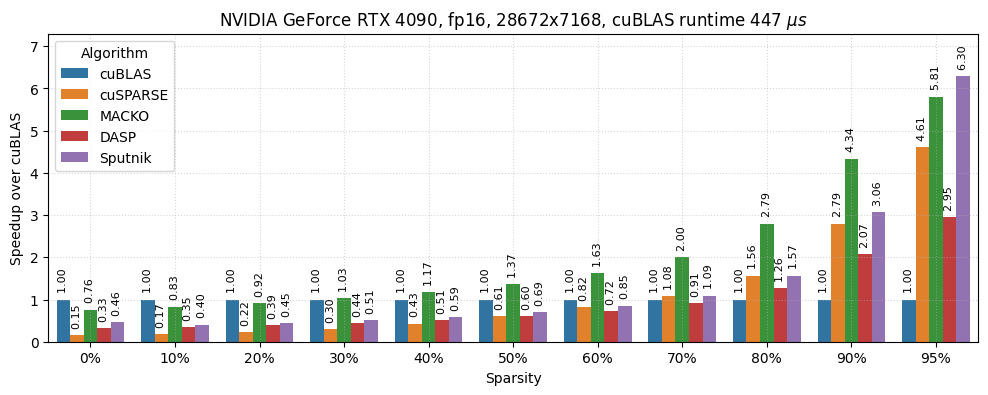

NVIDIA GeForce RTX 4090, fp16, 7168x28672, cuBLAS runtime 449 $\mu s$


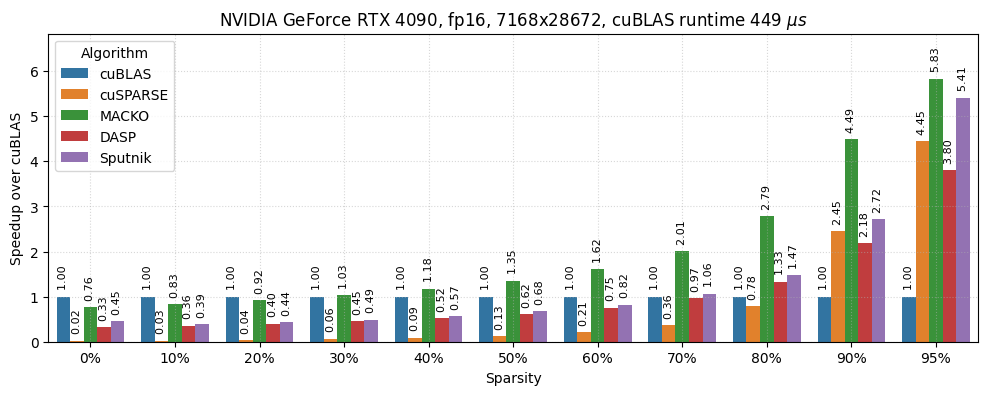

NVIDIA GeForce RTX 4090, fp16, 27648x9216, cuBLAS runtime 547 $\mu s$


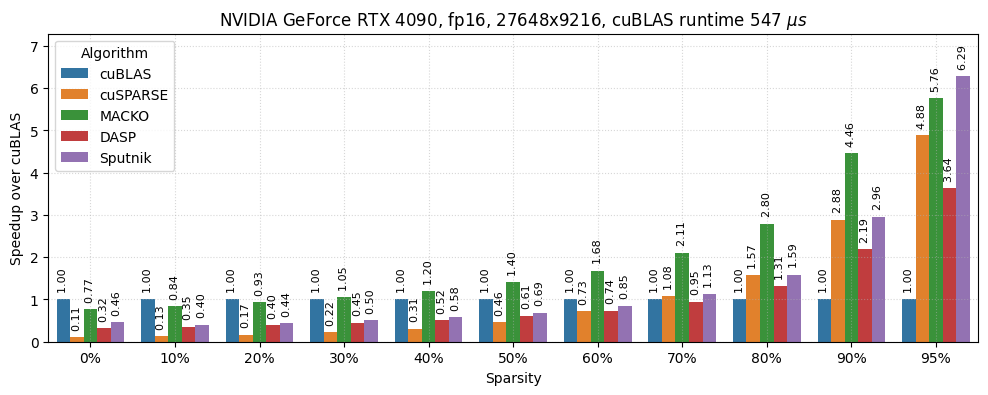

NVIDIA GeForce RTX 4090, fp16, 9216x9216, cuBLAS runtime 202 $\mu s$


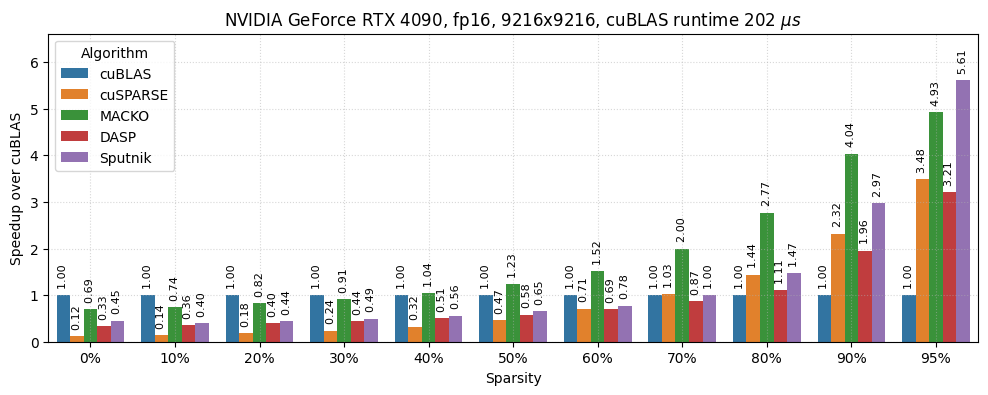

NVIDIA GeForce RTX 4090, fp16, 36864x9216, cuBLAS runtime 720 $\mu s$


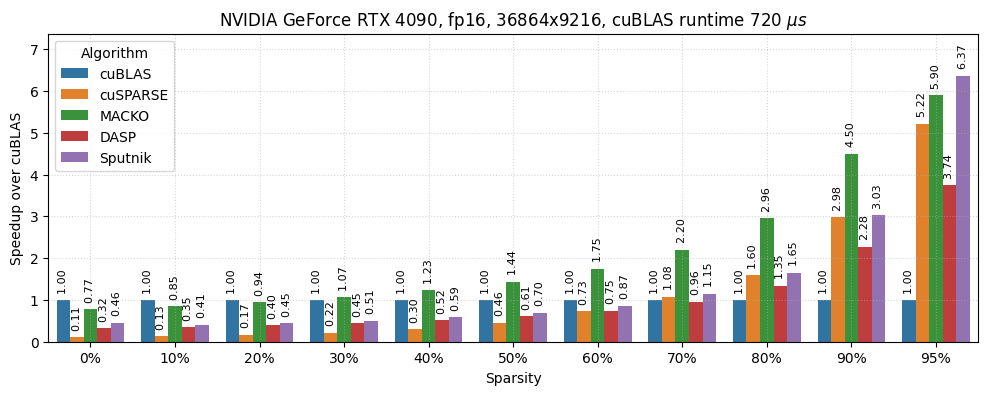

NVIDIA GeForce RTX 4090, fp16, 9216x36864, cuBLAS runtime 723 $\mu s$


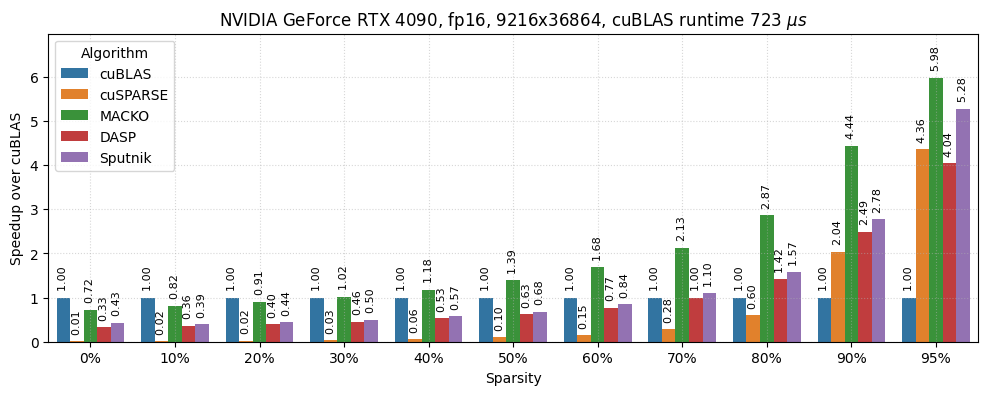

NVIDIA GeForce RTX 4090, fp16, 36864x12288, cuBLAS runtime 950 $\mu s$


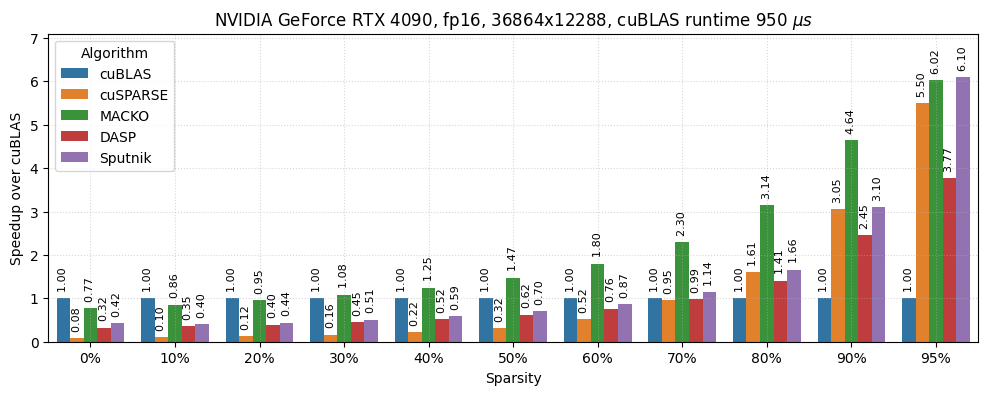

NVIDIA GeForce RTX 4090, fp16, 12288x12288, cuBLAS runtime 336 $\mu s$


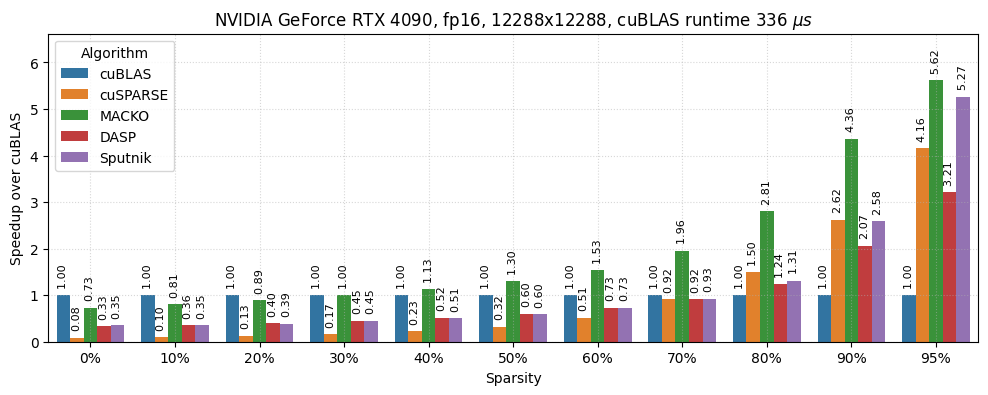

NVIDIA GeForce RTX 4090, fp16, 49152x12288, cuBLAS runtime 1258 $\mu s$


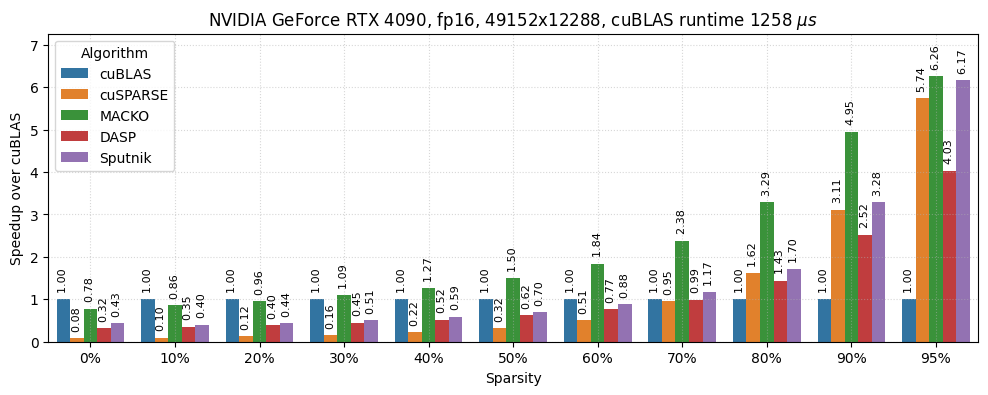

NVIDIA GeForce RTX 4090, fp16, 12288x49152, cuBLAS runtime 1327 $\mu s$


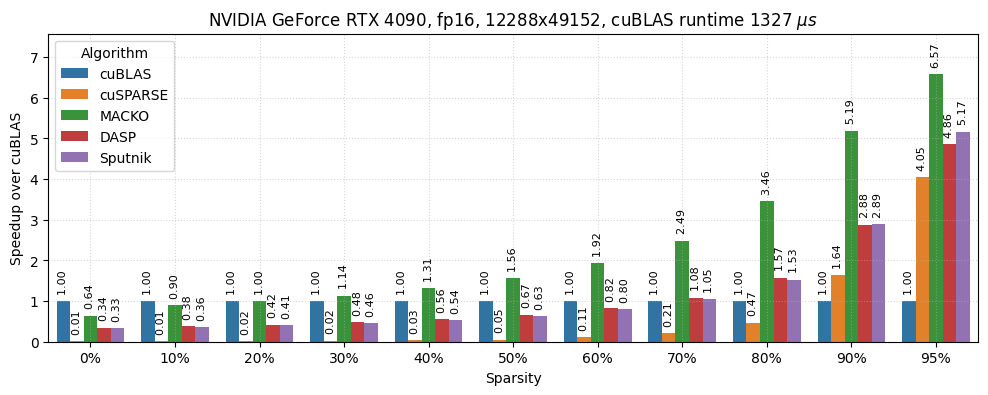

NVIDIA GeForce RTX 3090, fp16, 4096x4096, cuBLAS runtime 54 $\mu s$


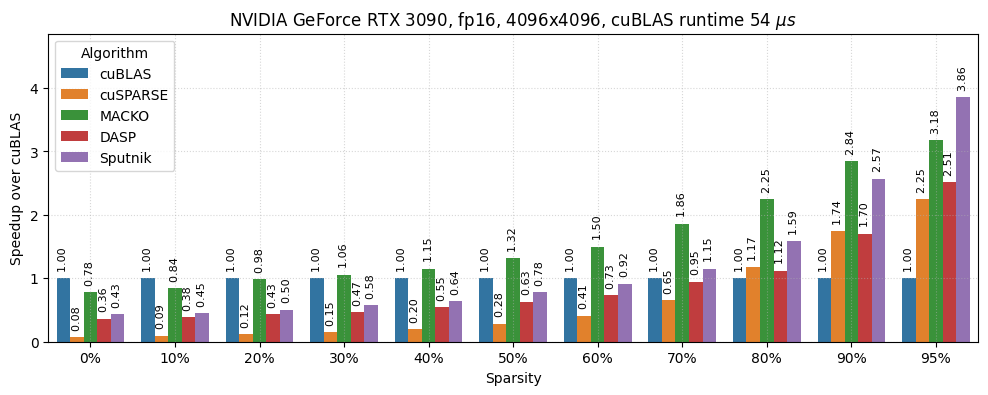

NVIDIA GeForce RTX 3090, fp16, 8192x8192, cuBLAS runtime 171 $\mu s$


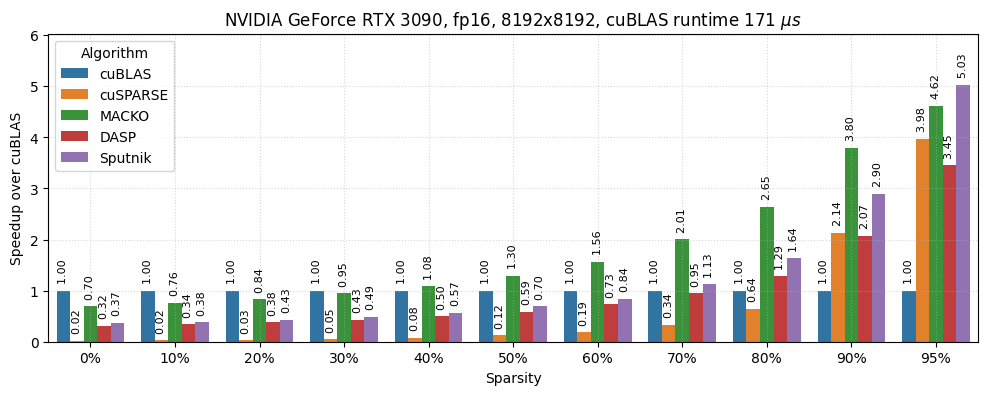

NVIDIA GeForce RTX 3090, fp16, 8192x29568, cuBLAS runtime 581 $\mu s$


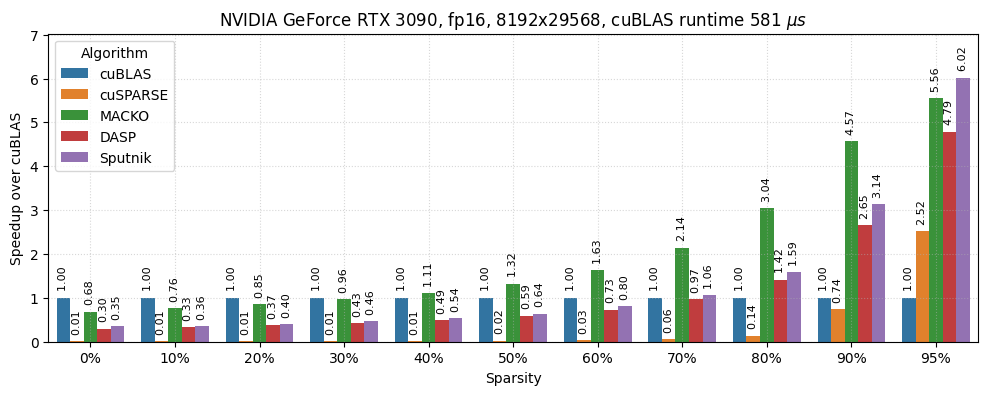

NVIDIA GeForce RTX 3090, fp16, 32000x5120, cuBLAS runtime 434 $\mu s$


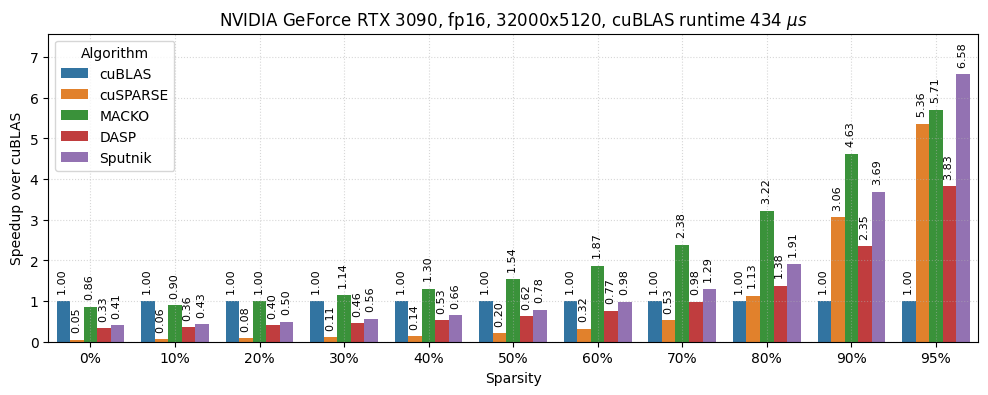

NVIDIA GeForce RTX 3090, fp16, 32000x8192, cuBLAS runtime 645 $\mu s$


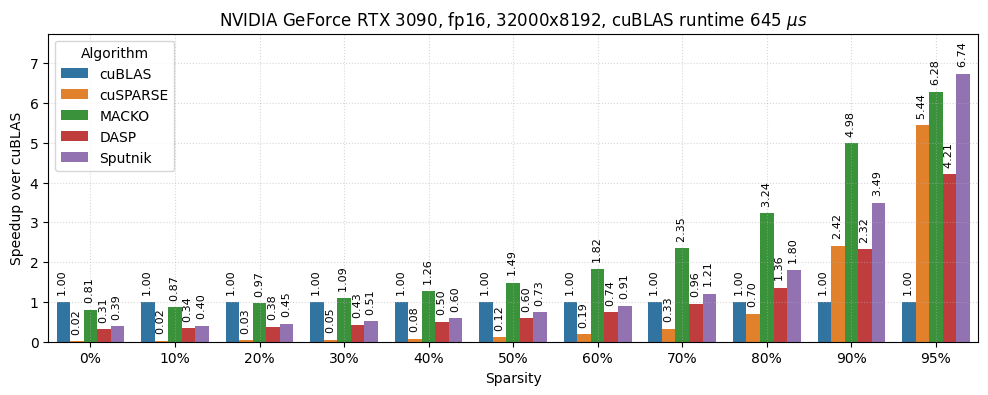

NVIDIA GeForce RTX 3090, fp16, 28672x8192, cuBLAS runtime 572 $\mu s$


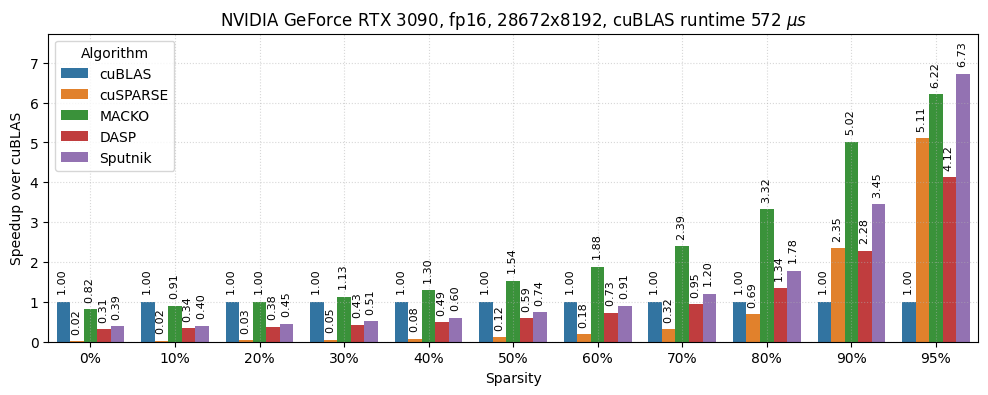

NVIDIA GeForce RTX 3090, fp16, 5120x5120, cuBLAS runtime 76 $\mu s$


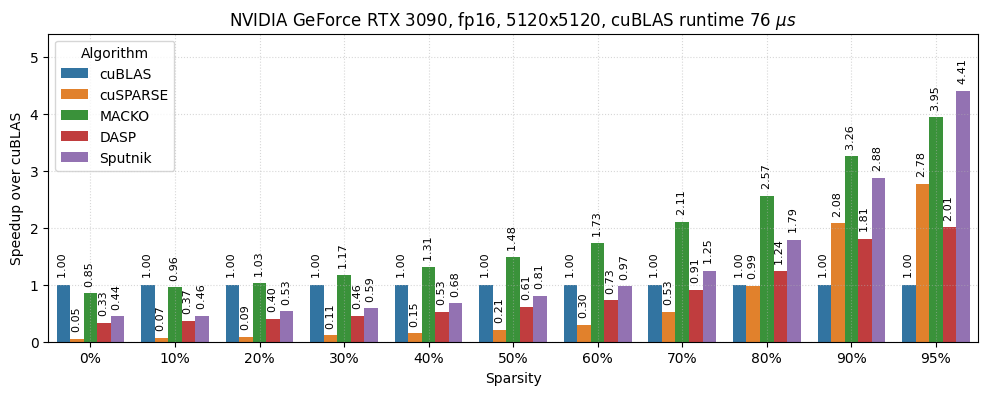

NVIDIA GeForce RTX 3090, fp16, 5120x13824, cuBLAS runtime 179 $\mu s$


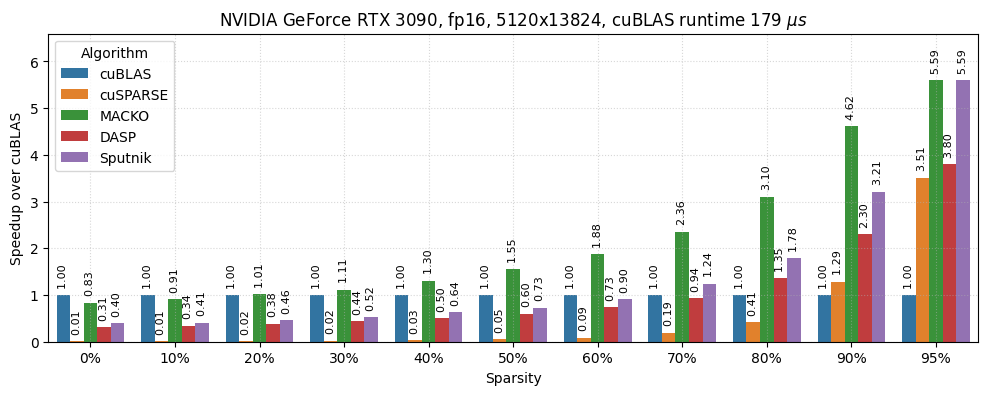

NVIDIA GeForce RTX 3090, fp16, 3584x20480, cuBLAS runtime 201 $\mu s$


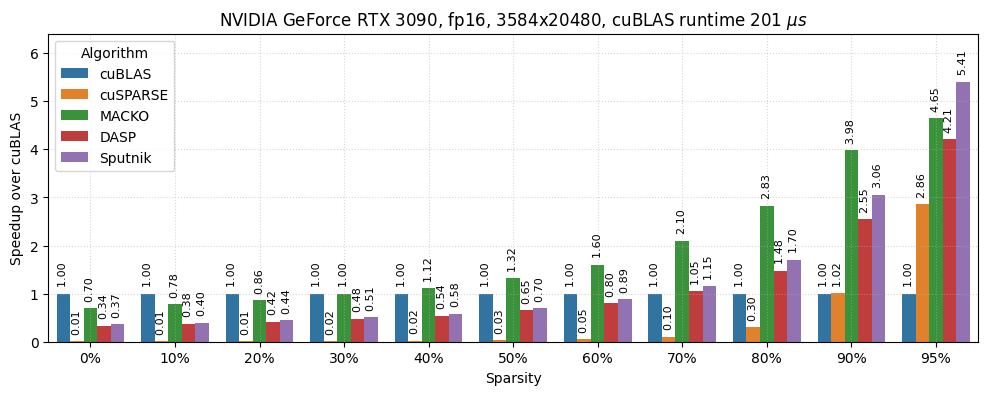

NVIDIA GeForce RTX 3090, fp16, 4096x11008, cuBLAS runtime 121 $\mu s$


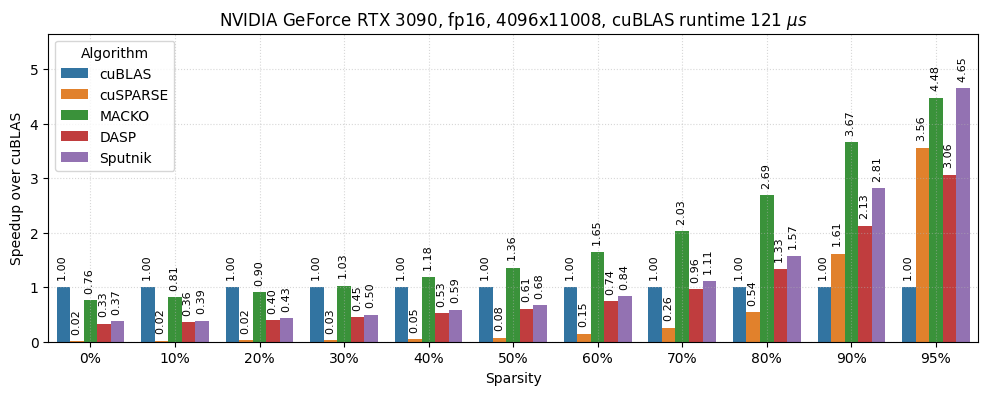

NVIDIA GeForce RTX 3090, fp16, 13824x5120, cuBLAS runtime 193 $\mu s$


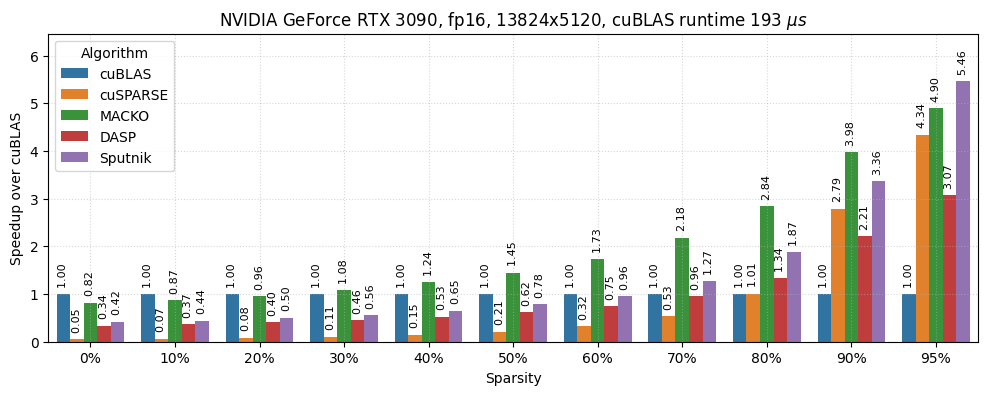

NVIDIA GeForce RTX 3090, fp16, 18944x3584, cuBLAS runtime 184 $\mu s$


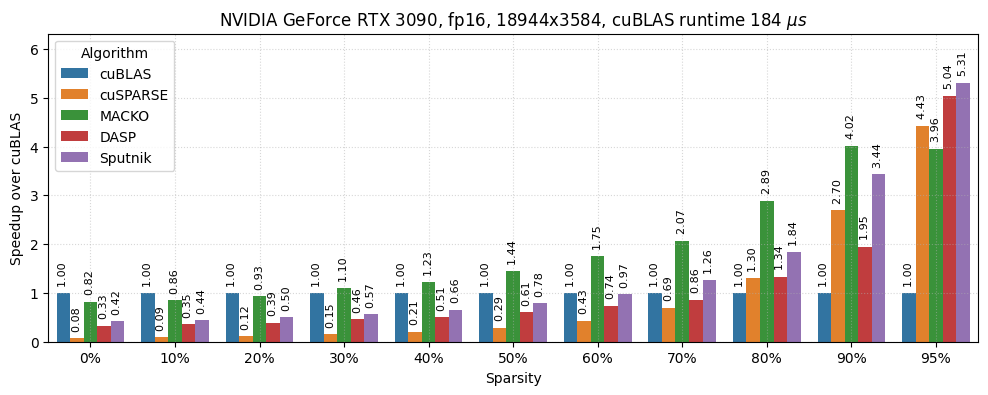

NVIDIA GeForce RTX 3090, fp16, 14336x4096, cuBLAS runtime 161 $\mu s$


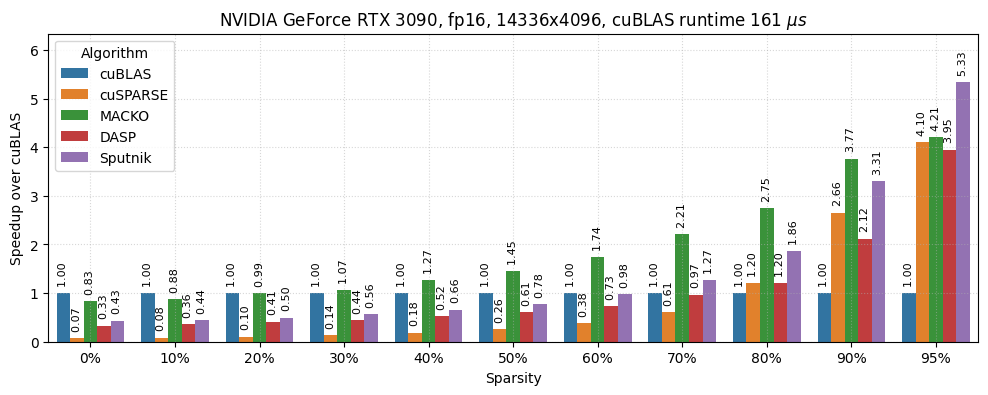

NVIDIA GeForce RTX 3090, fp16, 4096x14336, cuBLAS runtime 158 $\mu s$


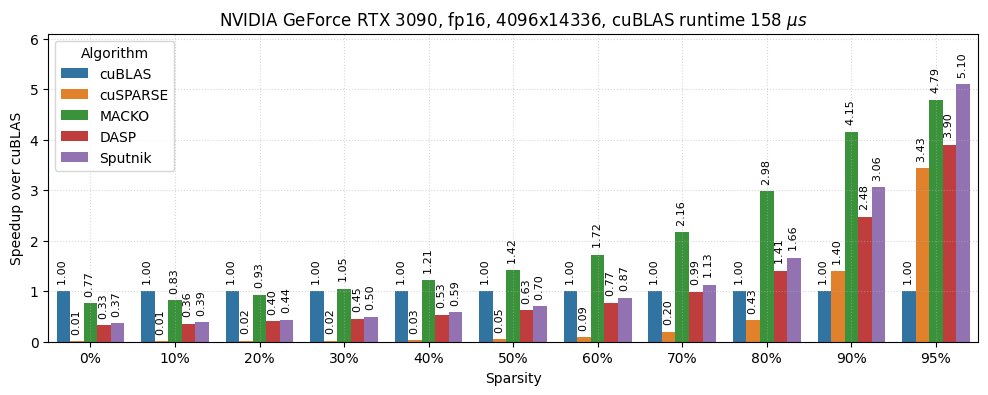

NVIDIA GeForce RTX 3090, fp16, 8192x28672, cuBLAS runtime 559 $\mu s$


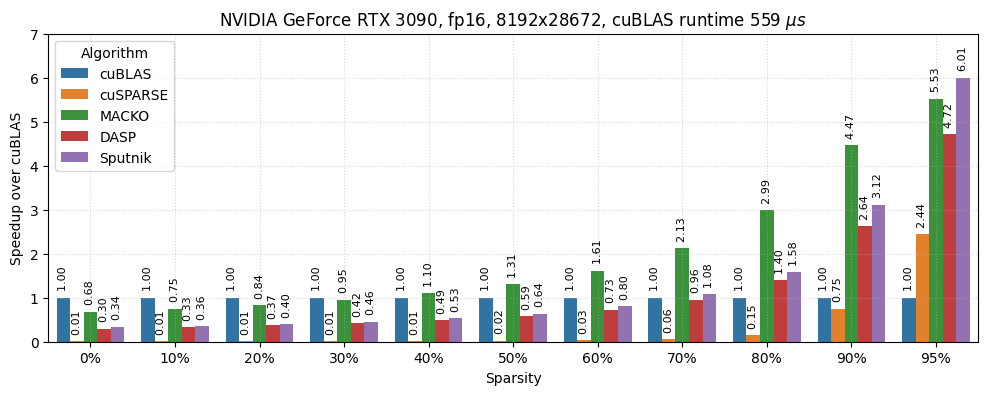

NVIDIA GeForce RTX 3090, fp16, 11008x4096, cuBLAS runtime 134 $\mu s$


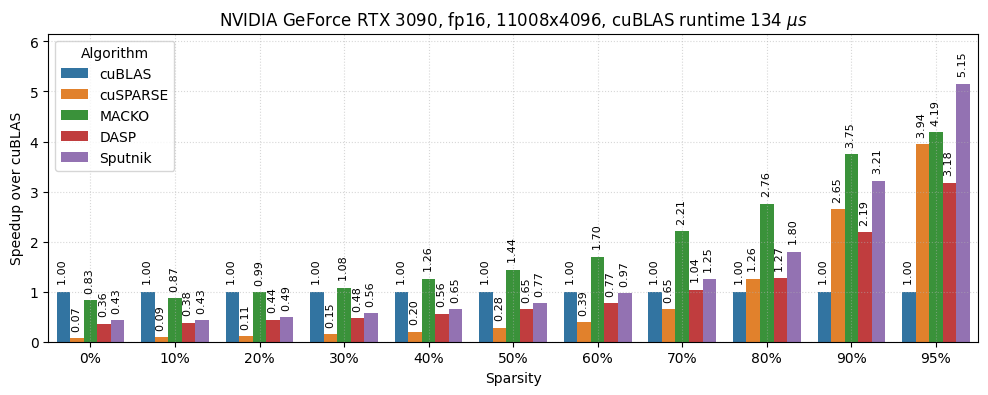

NVIDIA GeForce RTX 3090, fp16, 32000x4096, cuBLAS runtime 363 $\mu s$


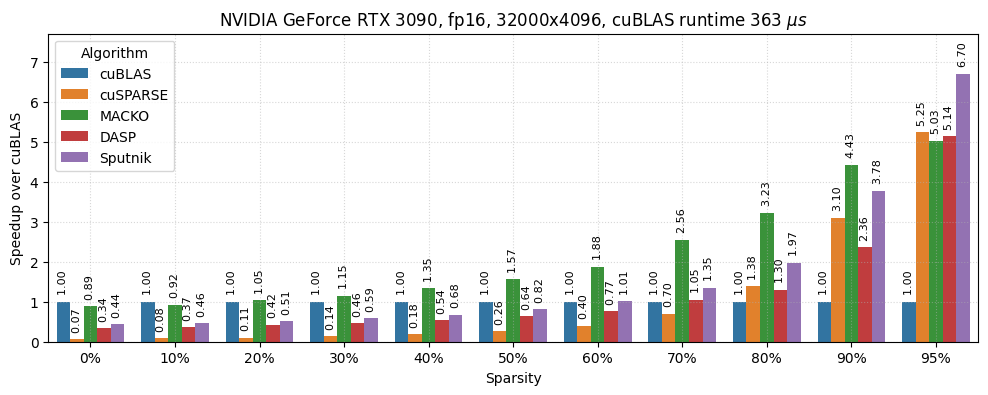

NVIDIA GeForce RTX 3090, fp16, 20480x3584, cuBLAS runtime 194 $\mu s$


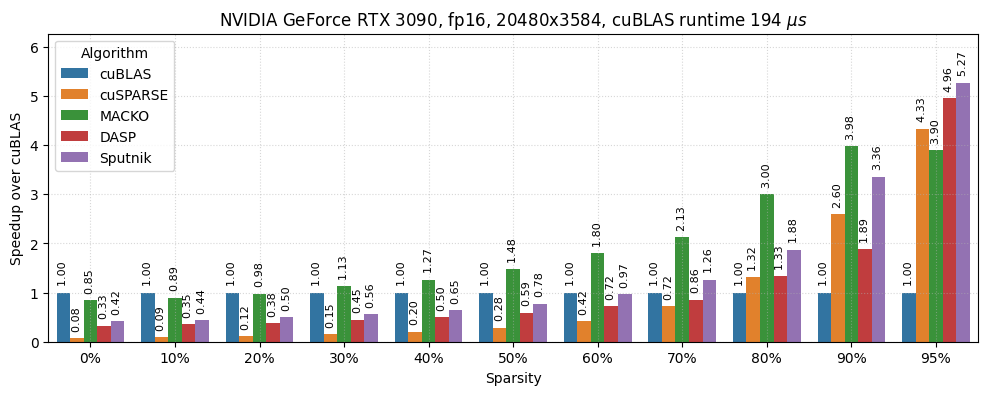

NVIDIA GeForce RTX 3090, fp16, 3584x18944, cuBLAS runtime 189 $\mu s$


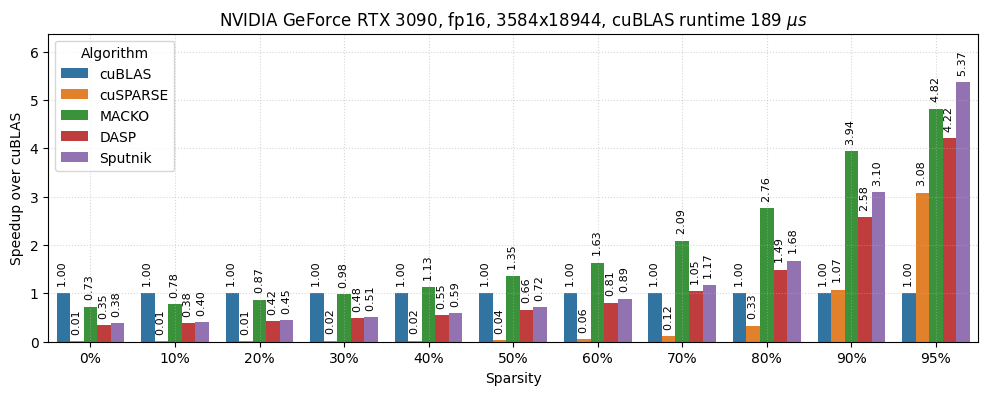

NVIDIA GeForce RTX 3090, fp16, 21504x7168, cuBLAS runtime 386 $\mu s$


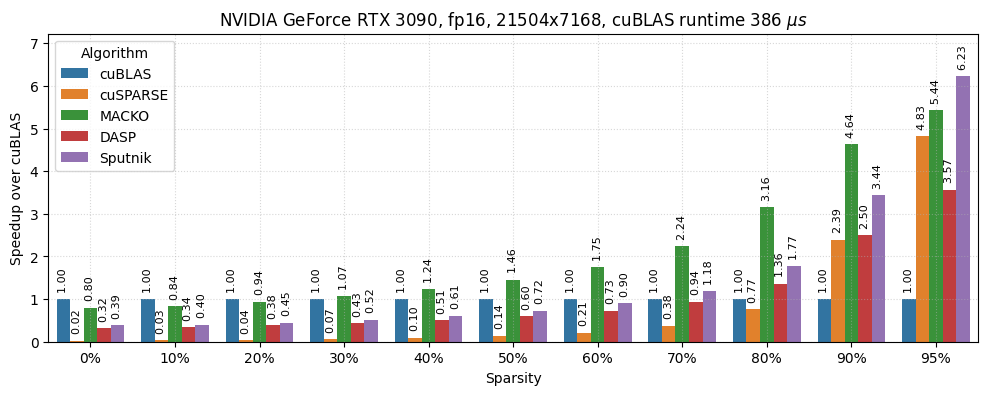

NVIDIA GeForce RTX 3090, fp16, 7168x7168, cuBLAS runtime 134 $\mu s$


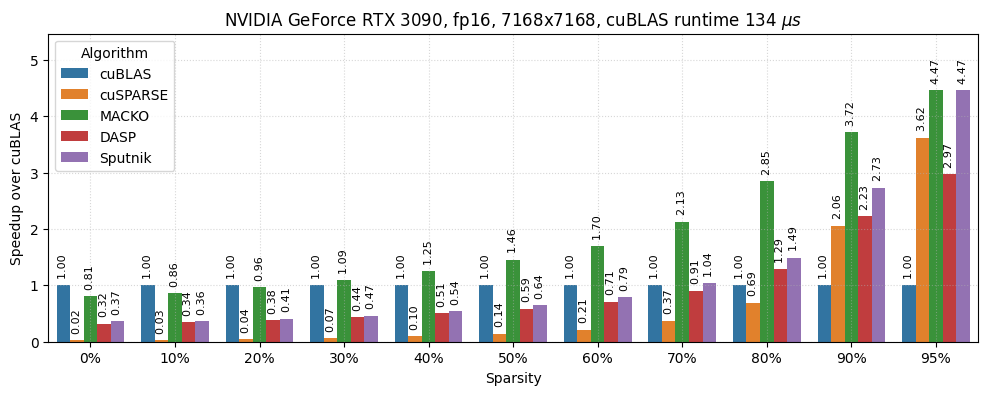

NVIDIA GeForce RTX 3090, fp16, 28672x7168, cuBLAS runtime 493 $\mu s$


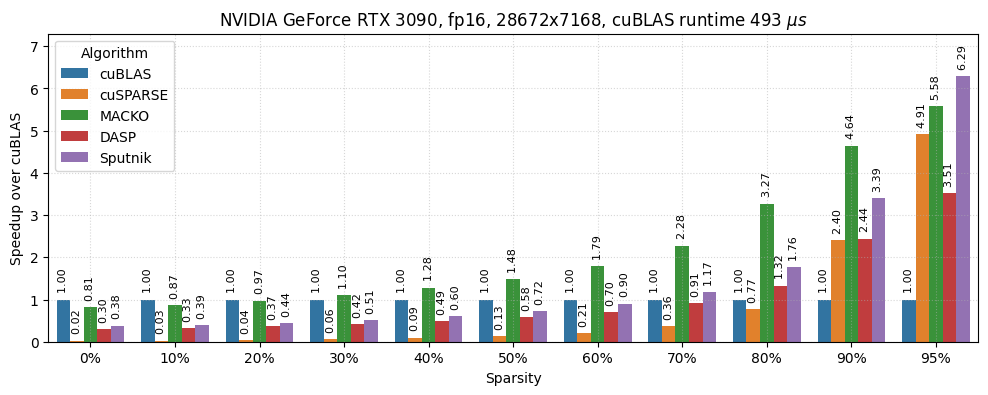

NVIDIA GeForce RTX 3090, fp16, 7168x28672, cuBLAS runtime 494 $\mu s$


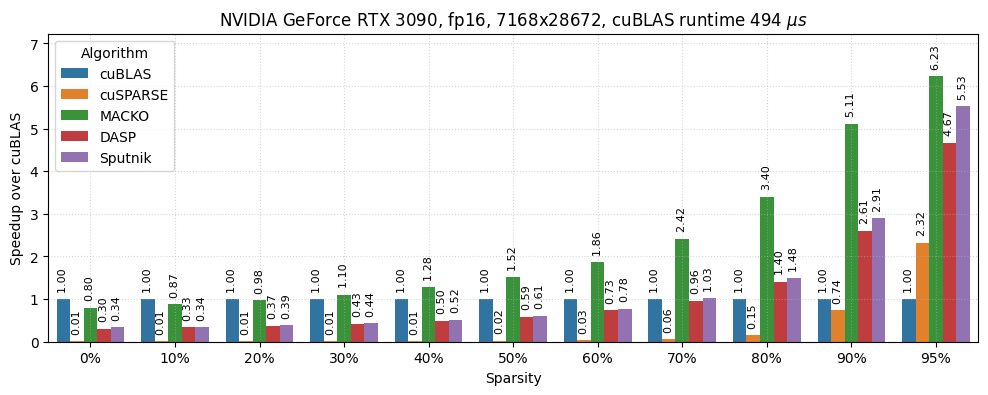

NVIDIA GeForce RTX 3090, fp16, 27648x9216, cuBLAS runtime 608 $\mu s$


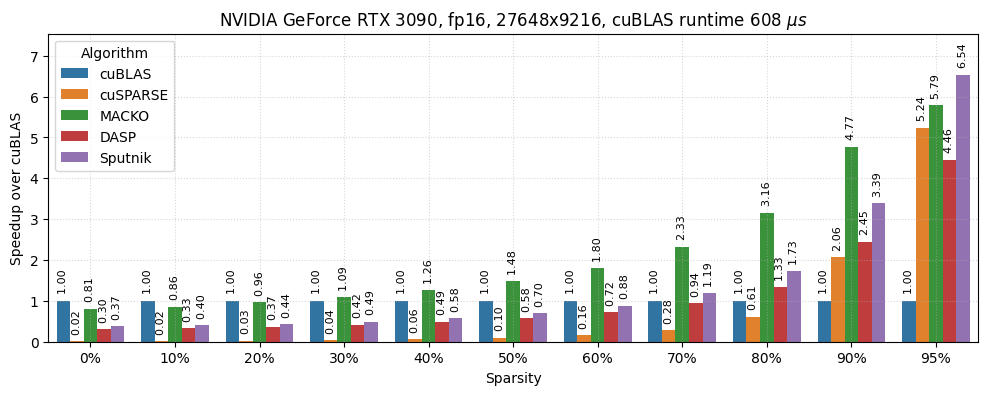

NVIDIA GeForce RTX 3090, fp16, 9216x9216, cuBLAS runtime 226 $\mu s$


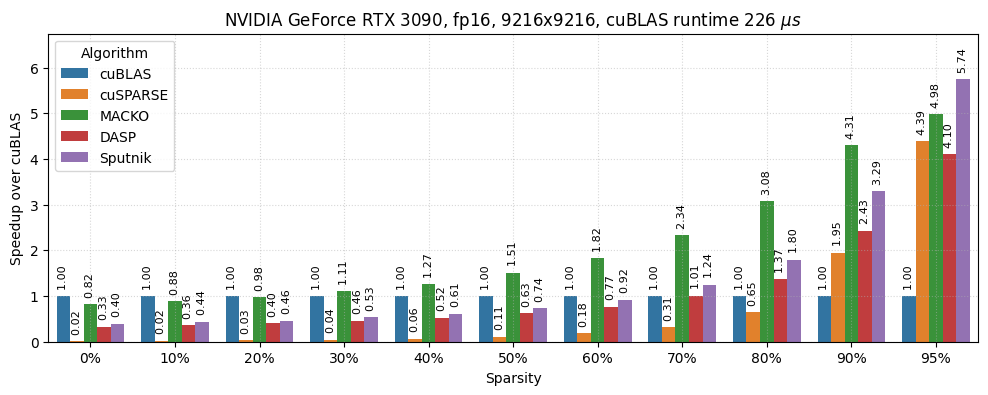

NVIDIA GeForce RTX 3090, fp16, 36864x9216, cuBLAS runtime 801 $\mu s$


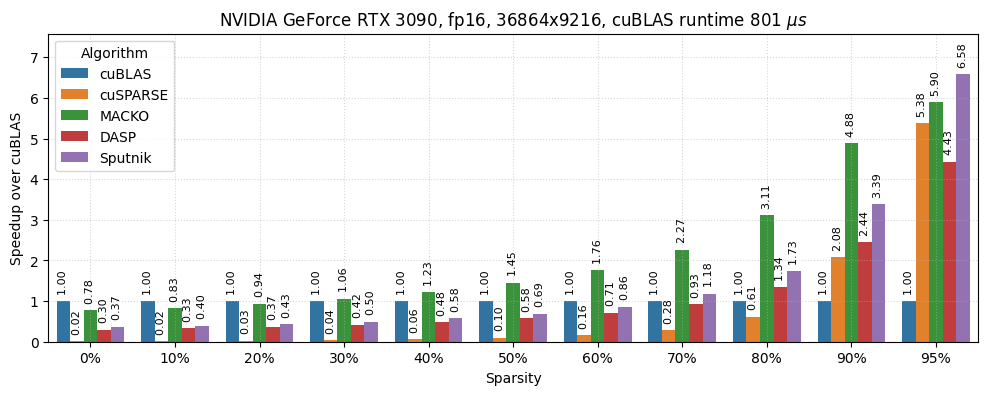

NVIDIA GeForce RTX 3090, fp16, 9216x36864, cuBLAS runtime 847 $\mu s$


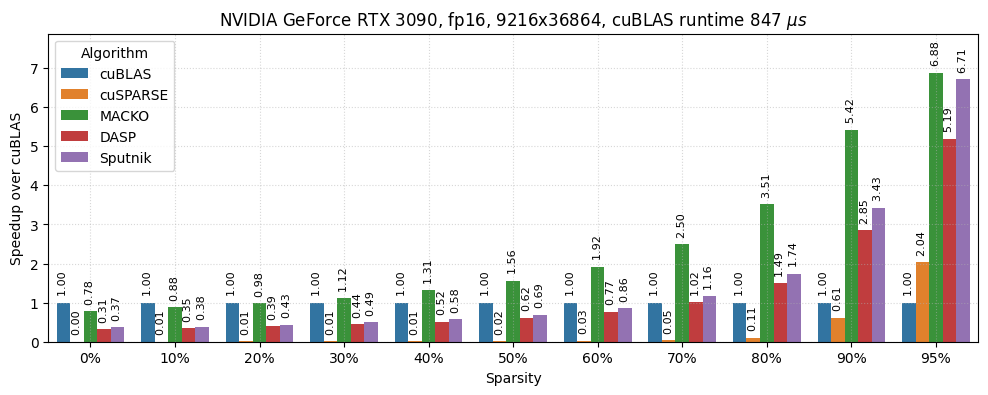

NVIDIA GeForce RTX 3090, fp16, 36864x12288, cuBLAS runtime 1136 $\mu s$


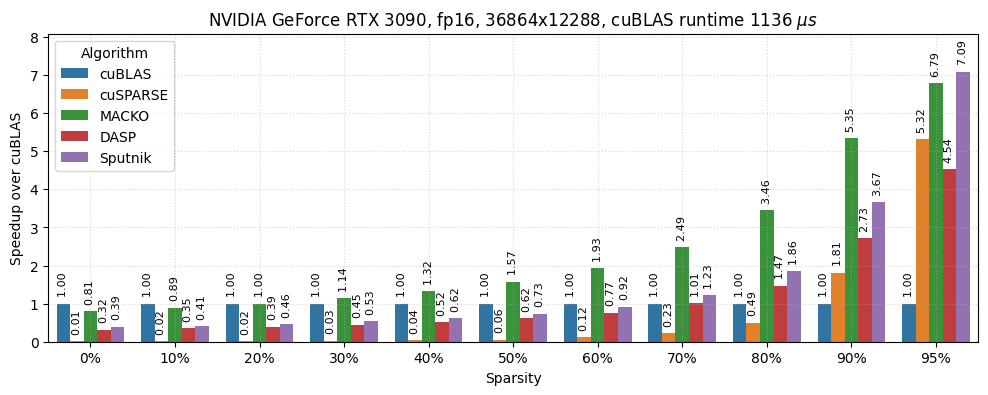

NVIDIA GeForce RTX 3090, fp16, 12288x12288, cuBLAS runtime 397 $\mu s$


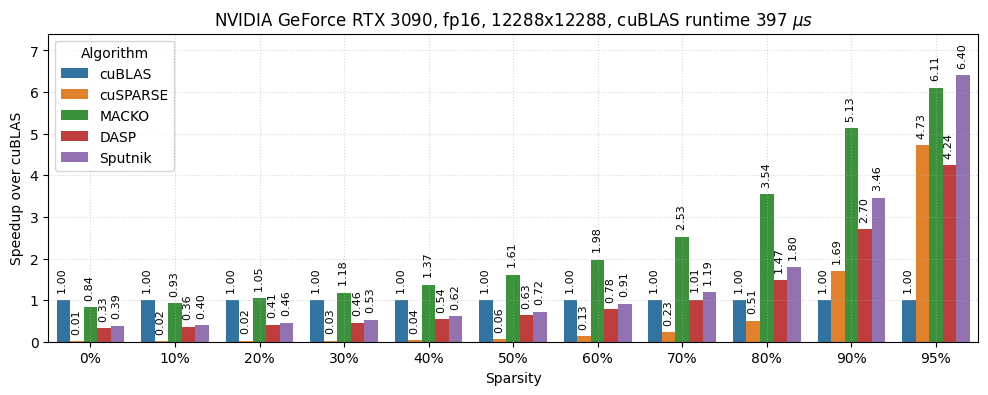

NVIDIA GeForce RTX 3090, fp16, 49152x12288, cuBLAS runtime 1678 $\mu s$


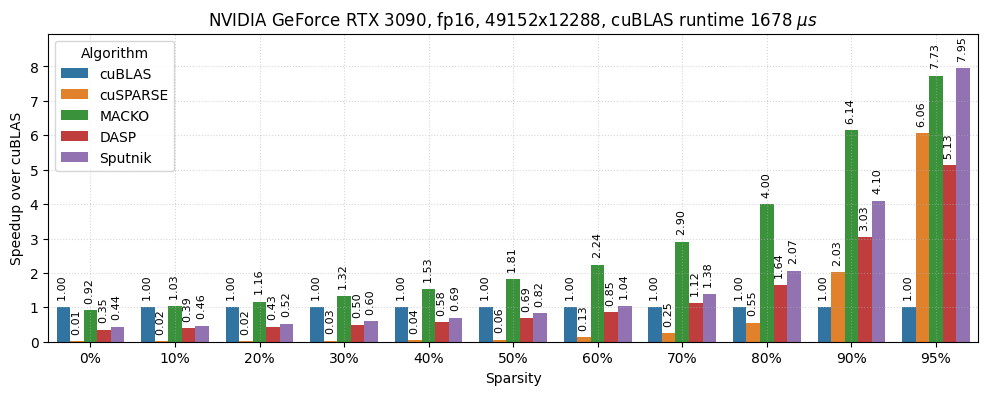

NVIDIA GeForce RTX 3090, fp16, 12288x49152, cuBLAS runtime 1985 $\mu s$


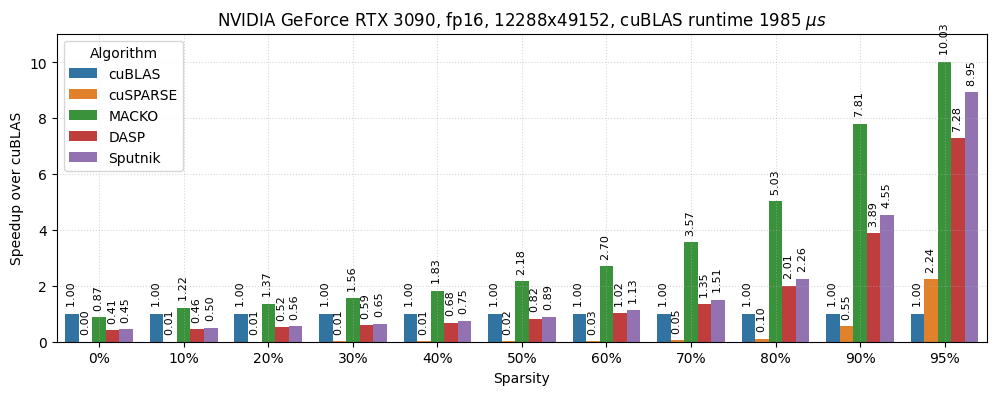

NVIDIA GeForce RTX 2080 SUPER, fp16, 4096x4096, cuBLAS runtime 86 $\mu s$


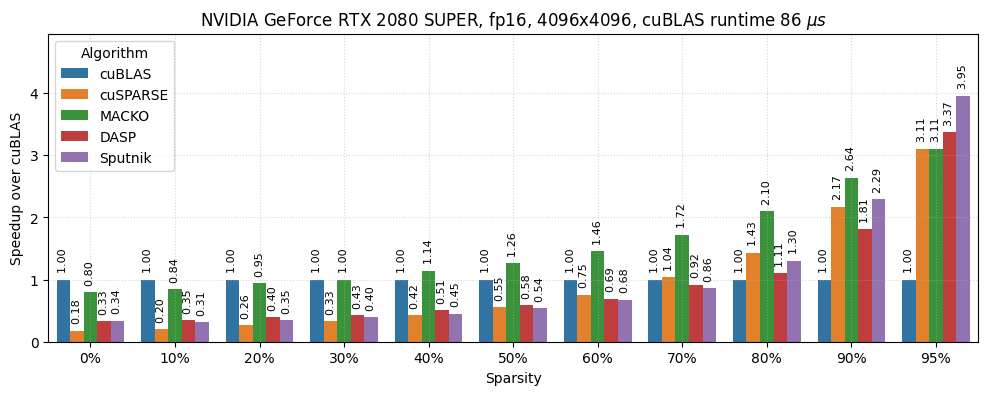

NVIDIA GeForce RTX 2080 SUPER, fp16, 8192x8192, cuBLAS runtime 325 $\mu s$


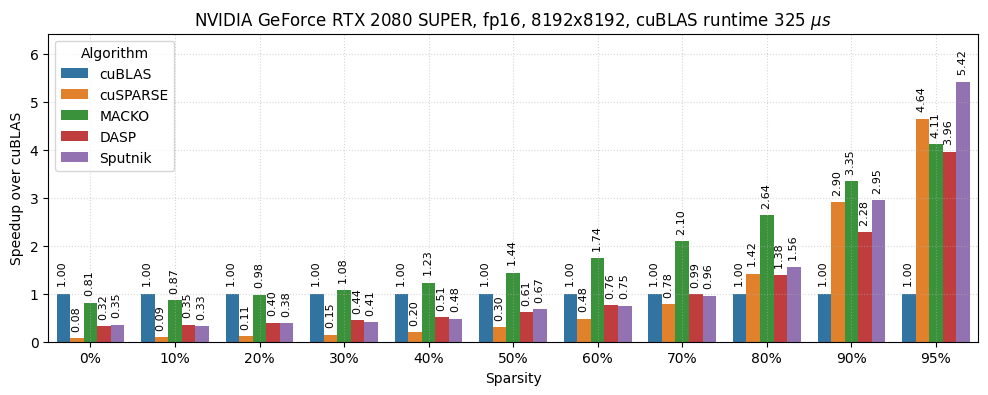

NVIDIA GeForce RTX 2080 SUPER, fp16, 8192x29568, cuBLAS runtime 1128 $\mu s$


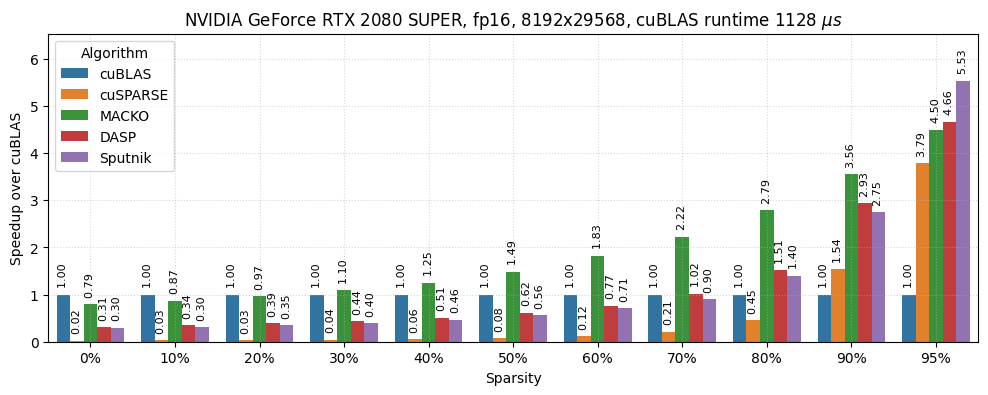

NVIDIA GeForce RTX 2080 SUPER, fp16, 32000x5120, cuBLAS runtime 768 $\mu s$


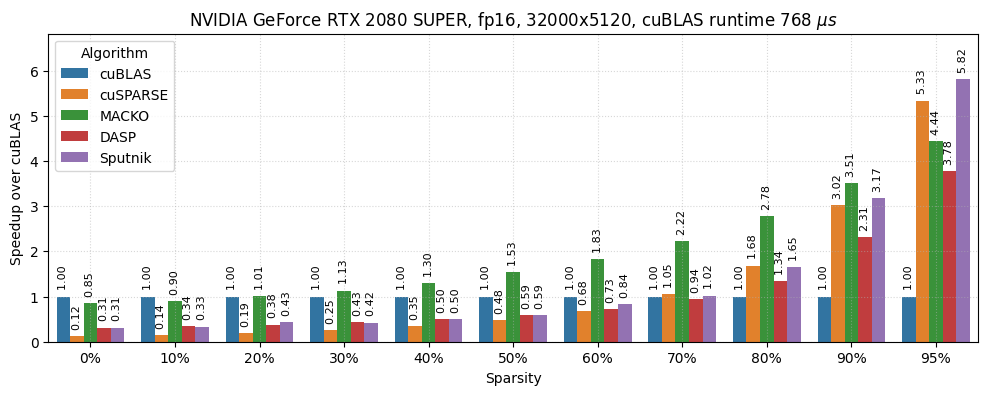

NVIDIA GeForce RTX 2080 SUPER, fp16, 32000x8192, cuBLAS runtime 1199 $\mu s$


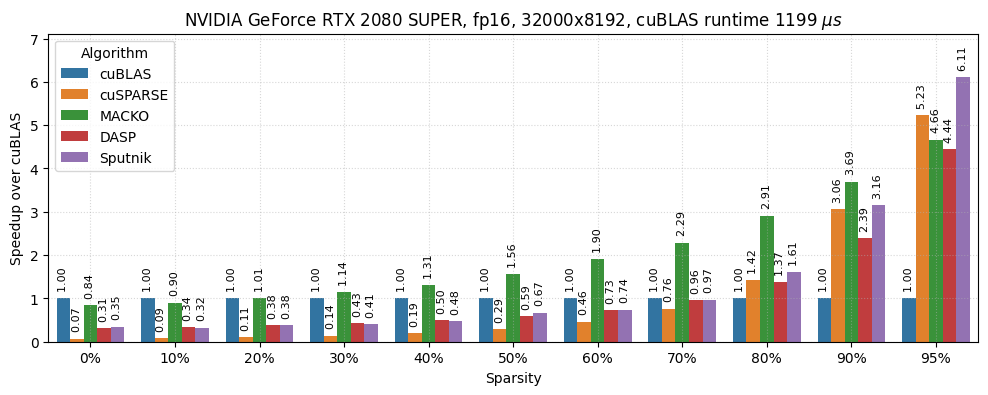

NVIDIA GeForce RTX 2080 SUPER, fp16, 28672x8192, cuBLAS runtime 1081 $\mu s$


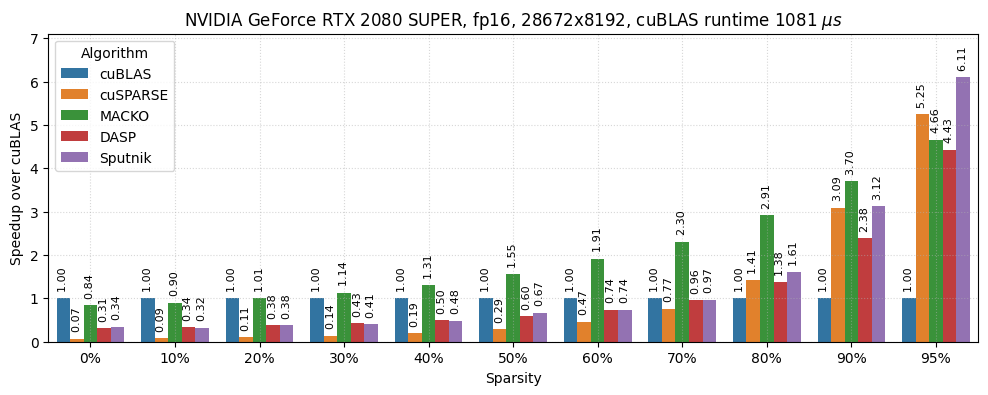

NVIDIA GeForce RTX 2080 SUPER, fp16, 5120x5120, cuBLAS runtime 132 $\mu s$


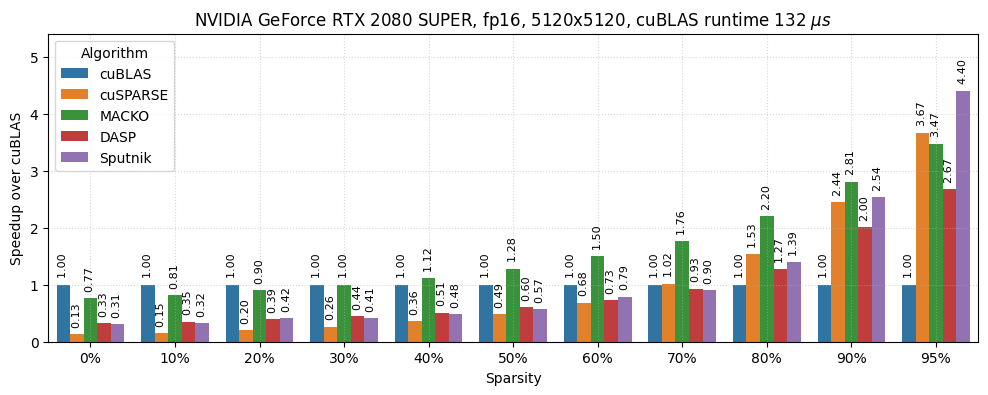

NVIDIA GeForce RTX 2080 SUPER, fp16, 5120x13824, cuBLAS runtime 351 $\mu s$


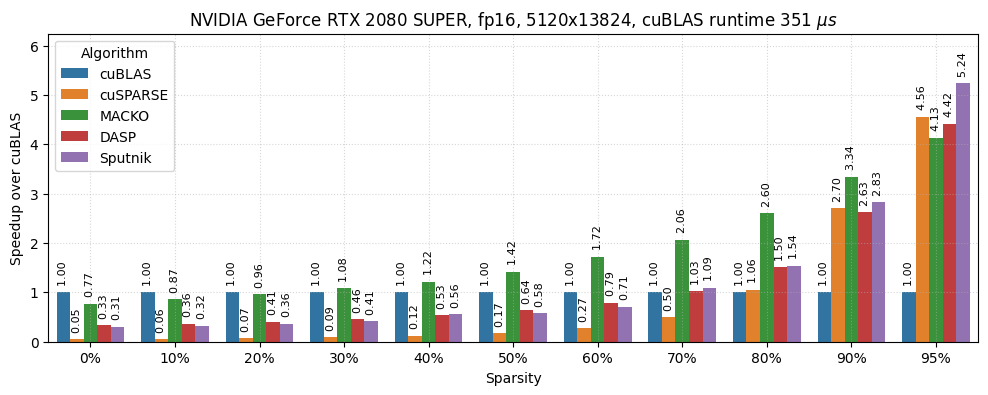

NVIDIA GeForce RTX 2080 SUPER, fp16, 3584x20480, cuBLAS runtime 357 $\mu s$


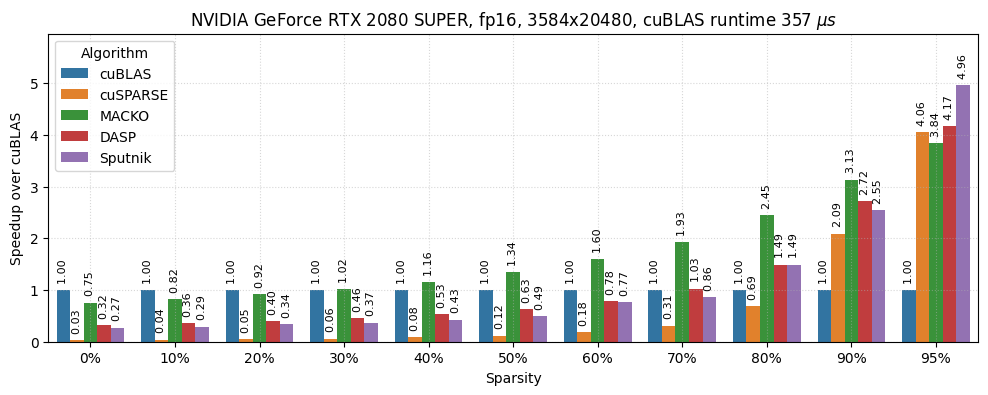

NVIDIA GeForce RTX 2080 SUPER, fp16, 4096x11008, cuBLAS runtime 223 $\mu s$


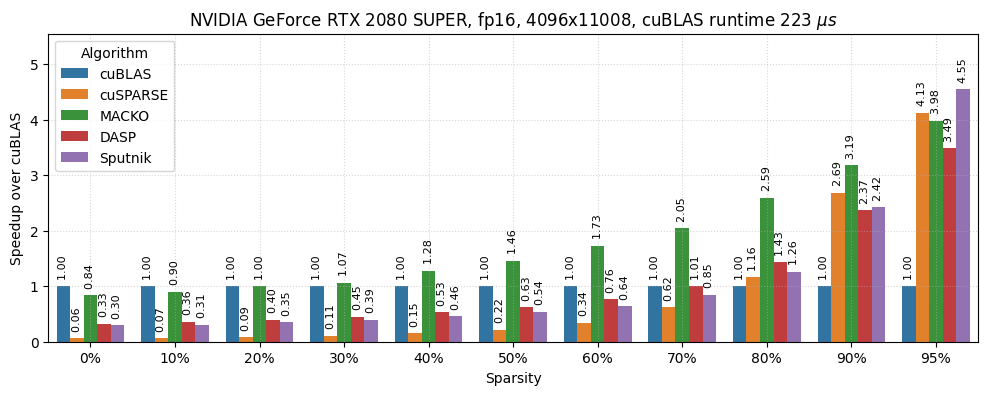

NVIDIA GeForce RTX 2080 SUPER, fp16, 13824x5120, cuBLAS runtime 340 $\mu s$


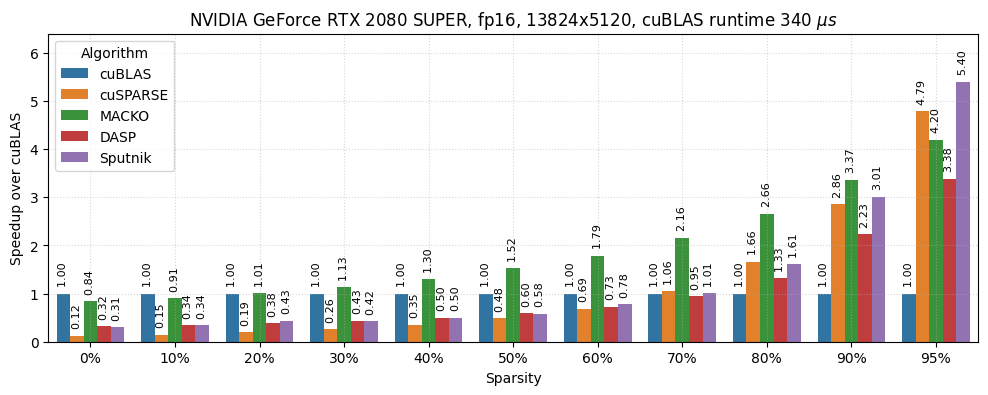

NVIDIA GeForce RTX 2080 SUPER, fp16, 18944x3584, cuBLAS runtime 330 $\mu s$


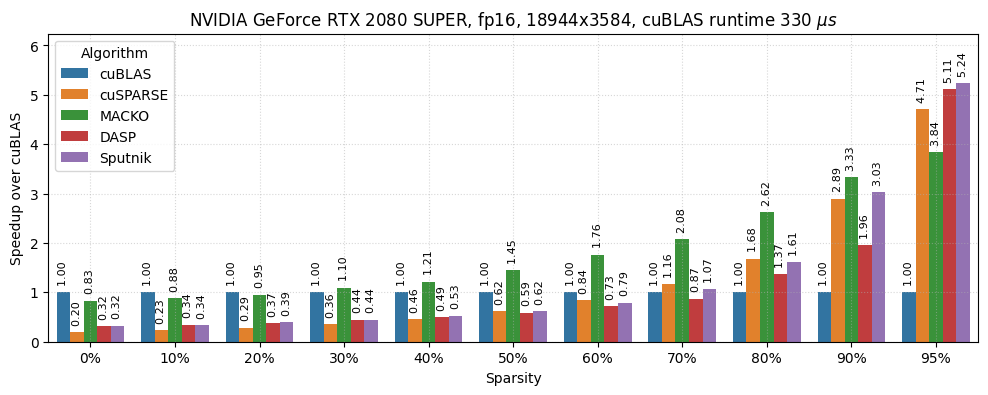

NVIDIA GeForce RTX 2080 SUPER, fp16, 14336x4096, cuBLAS runtime 273 $\mu s$


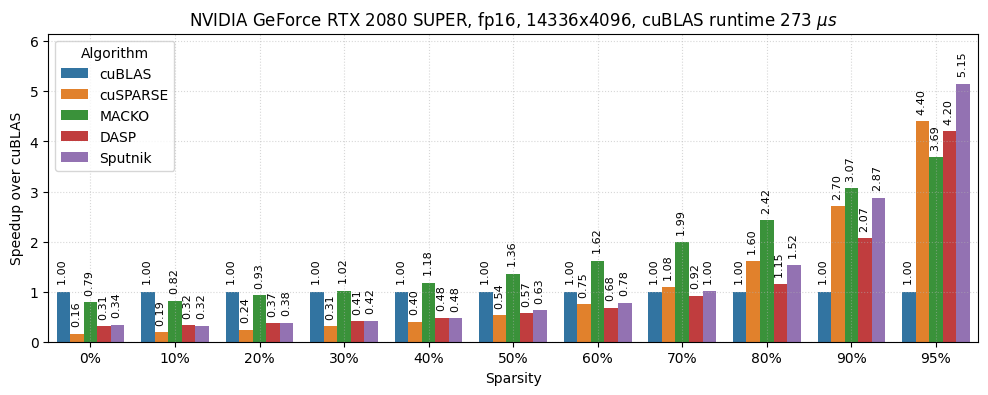

NVIDIA GeForce RTX 2080 SUPER, fp16, 4096x14336, cuBLAS runtime 288 $\mu s$


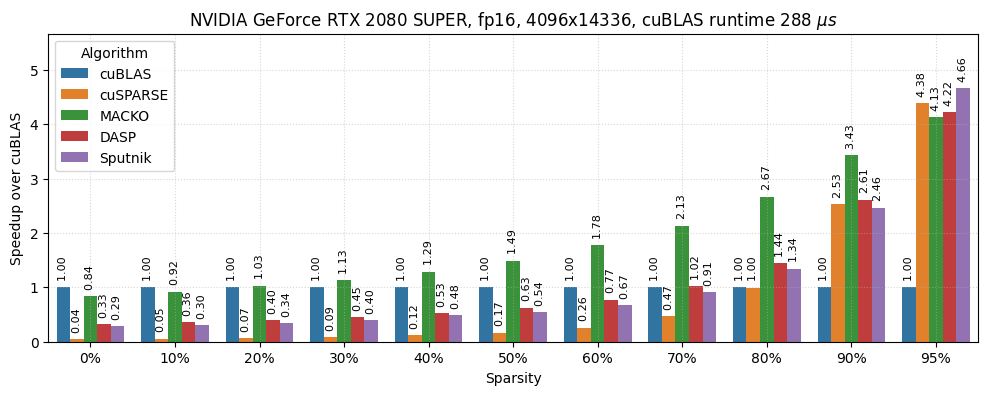

NVIDIA GeForce RTX 2080 SUPER, fp16, 8192x28672, cuBLAS runtime 1086 $\mu s$


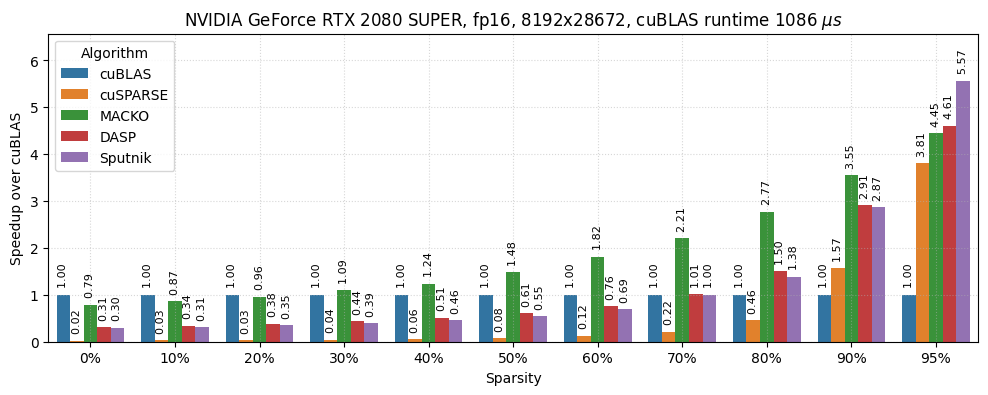

NVIDIA GeForce RTX 2080 SUPER, fp16, 11008x4096, cuBLAS runtime 211 $\mu s$


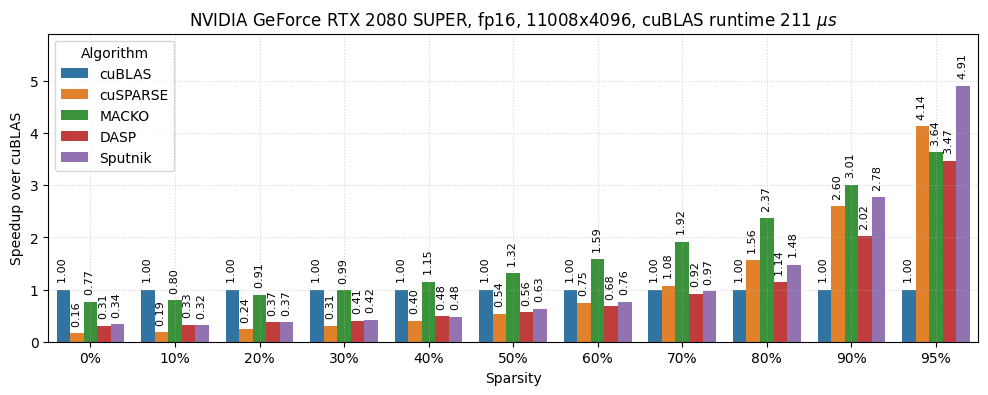

NVIDIA GeForce RTX 2080 SUPER, fp16, 32000x4096, cuBLAS runtime 594 $\mu s$


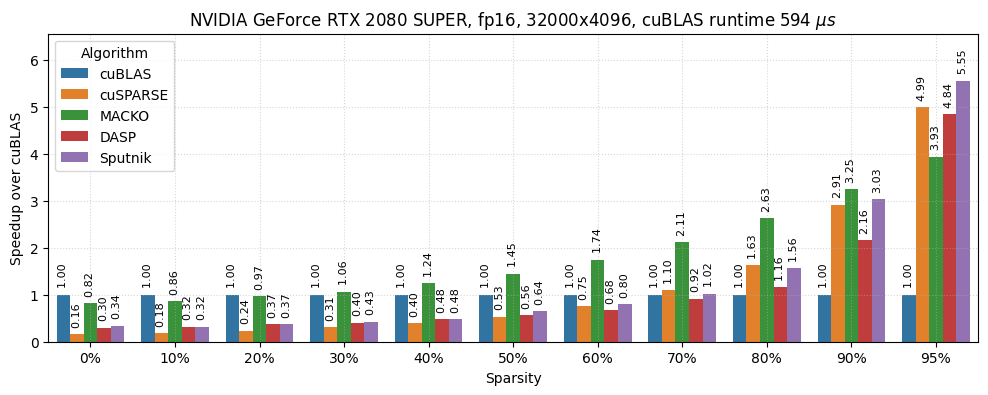

NVIDIA GeForce RTX 2080 SUPER, fp16, 20480x3584, cuBLAS runtime 355 $\mu s$


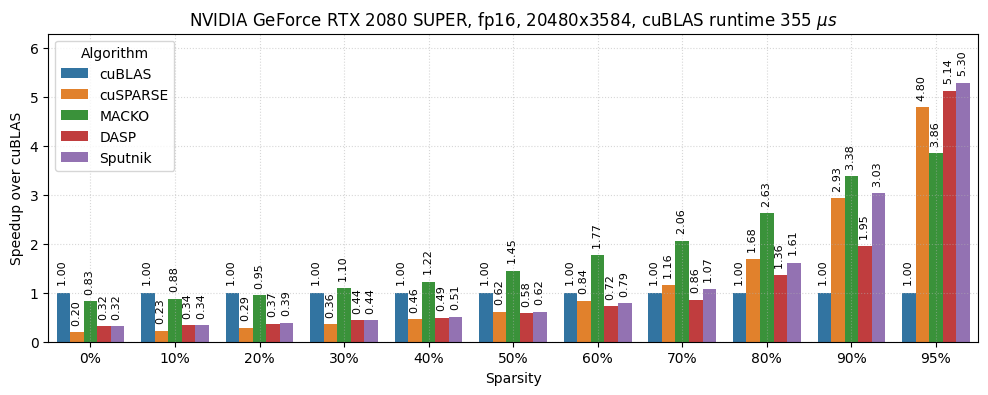

NVIDIA GeForce RTX 2080 SUPER, fp16, 3584x18944, cuBLAS runtime 334 $\mu s$


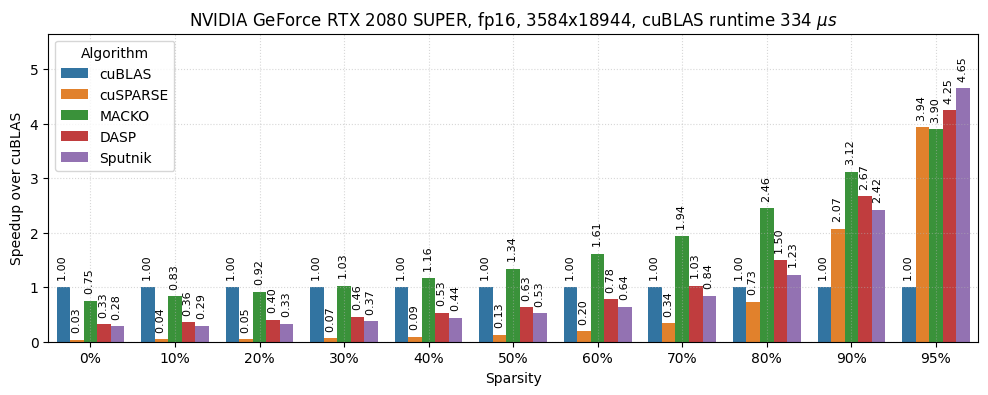

NVIDIA GeForce RTX 2080 SUPER, fp16, 21504x7168, cuBLAS runtime 732 $\mu s$


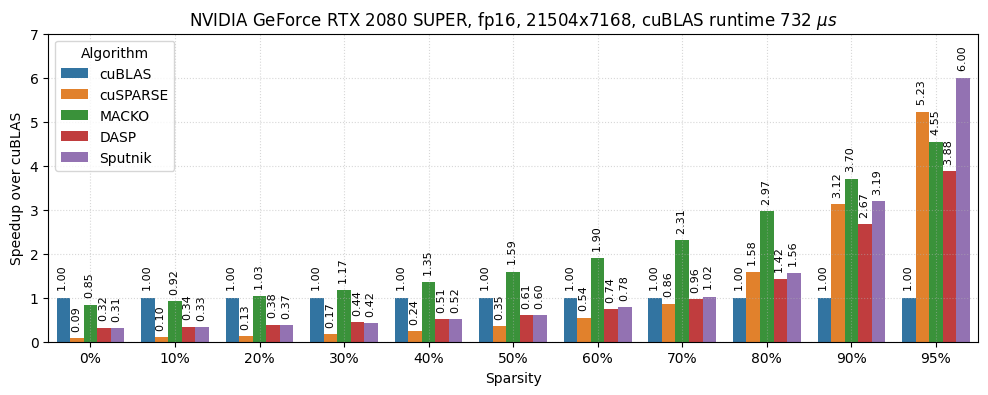

NVIDIA GeForce RTX 2080 SUPER, fp16, 7168x7168, cuBLAS runtime 254 $\mu s$


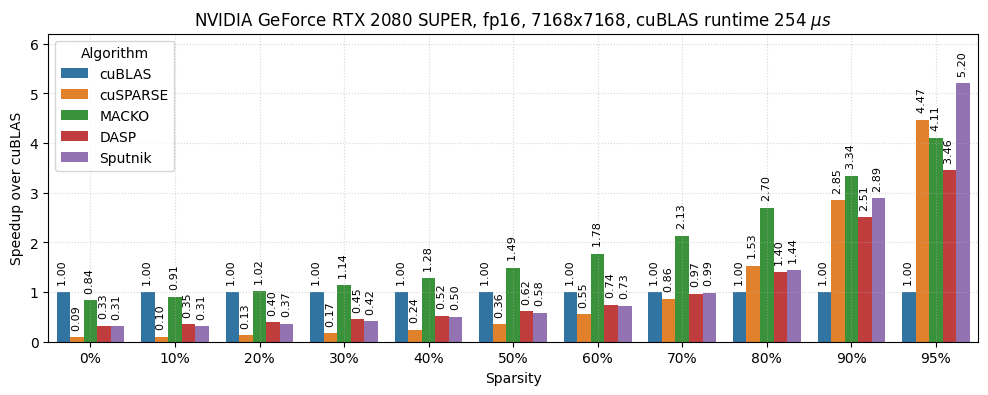

NVIDIA GeForce RTX 2080 SUPER, fp16, 28672x7168, cuBLAS runtime 957 $\mu s$


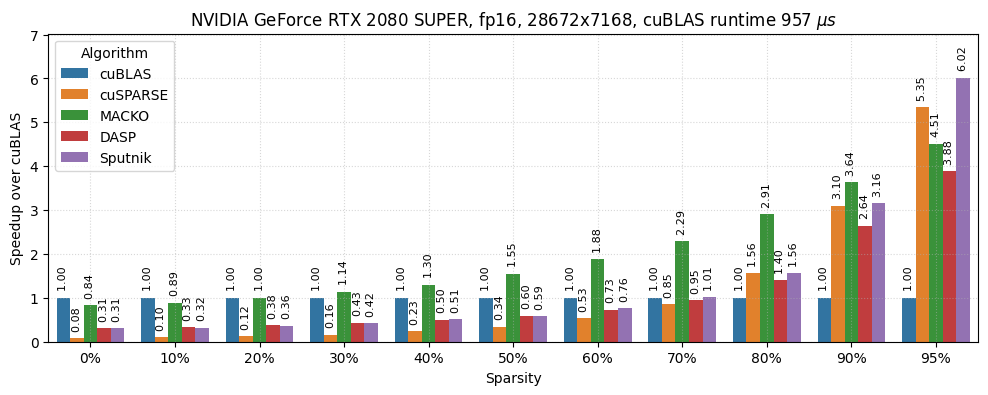

NVIDIA GeForce RTX 2080 SUPER, fp16, 7168x28672, cuBLAS runtime 959 $\mu s$


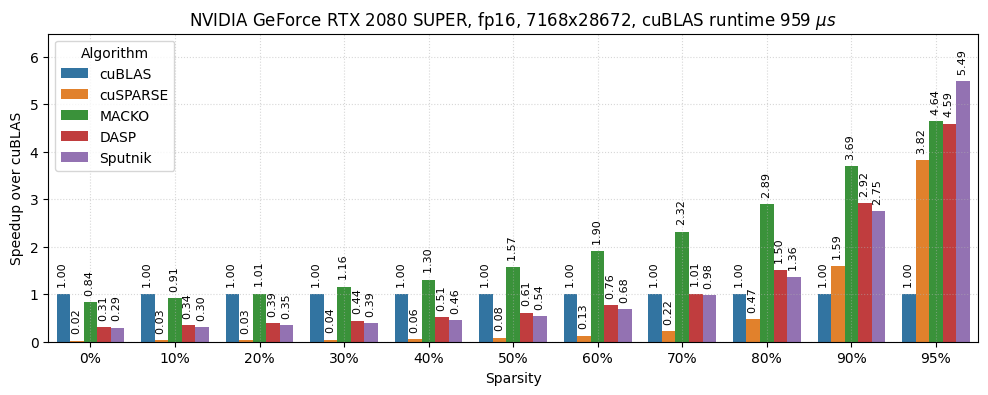

NVIDIA GeForce RTX 2080 SUPER, fp16, 27648x9216, cuBLAS runtime 1172 $\mu s$


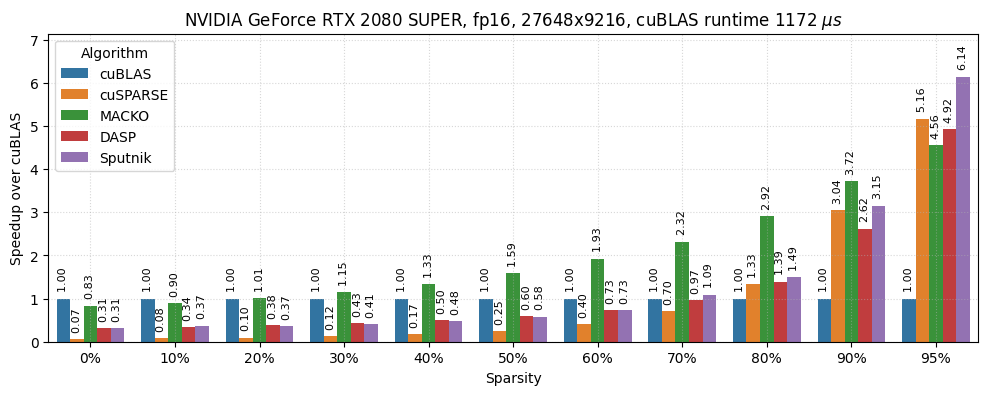

NVIDIA GeForce RTX 2080 SUPER, fp16, 9216x9216, cuBLAS runtime 408 $\mu s$


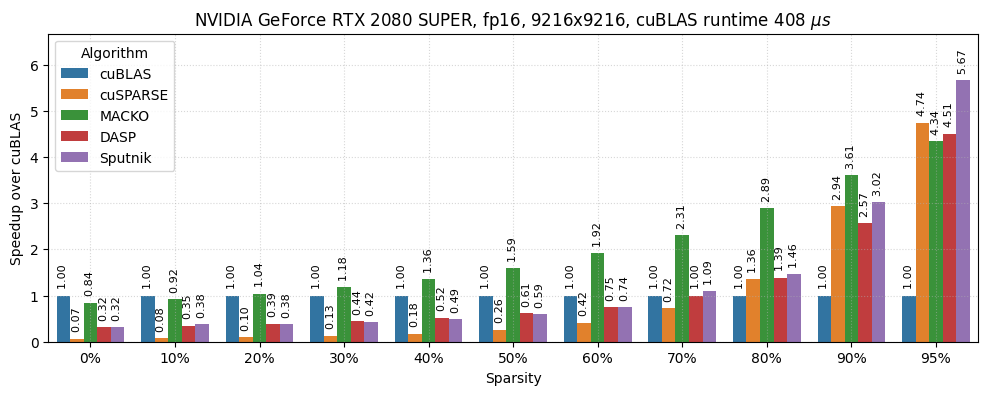

NVIDIA GeForce RTX 2080 SUPER, fp16, 36864x9216, cuBLAS runtime 1534 $\mu s$


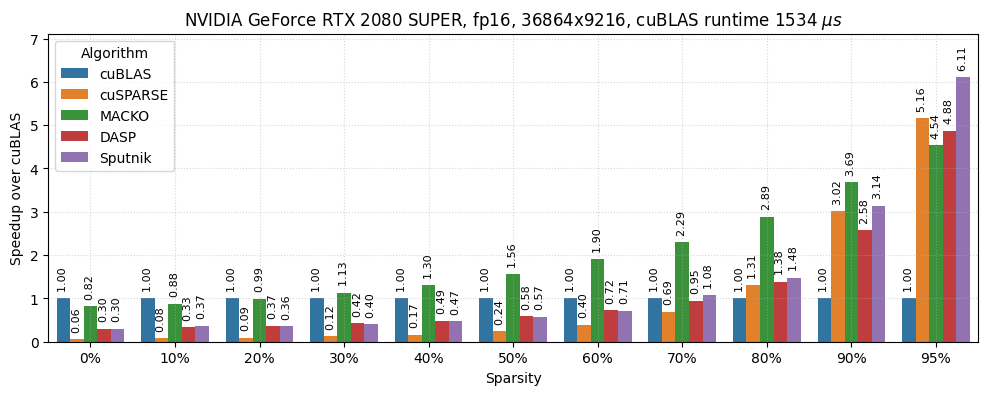

NVIDIA GeForce RTX 2080 SUPER, fp16, 9216x36864, cuBLAS runtime 1537 $\mu s$


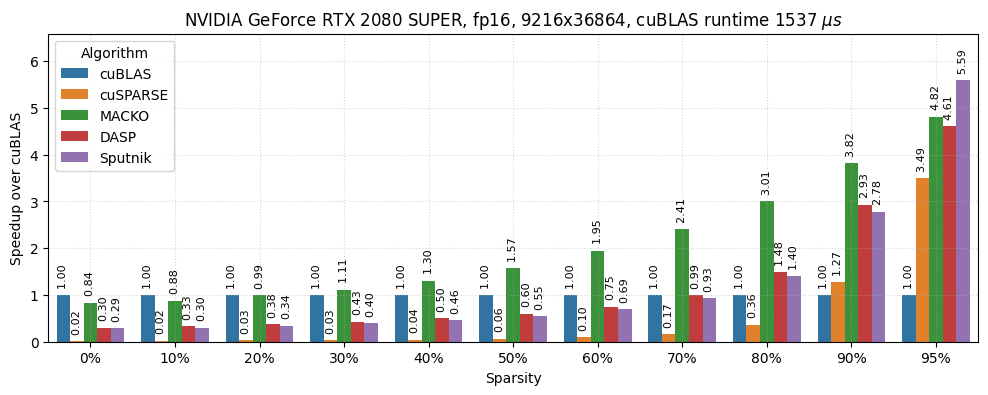

NVIDIA GeForce RTX 2080 SUPER, fp16, 36864x12288, cuBLAS runtime 2018 $\mu s$


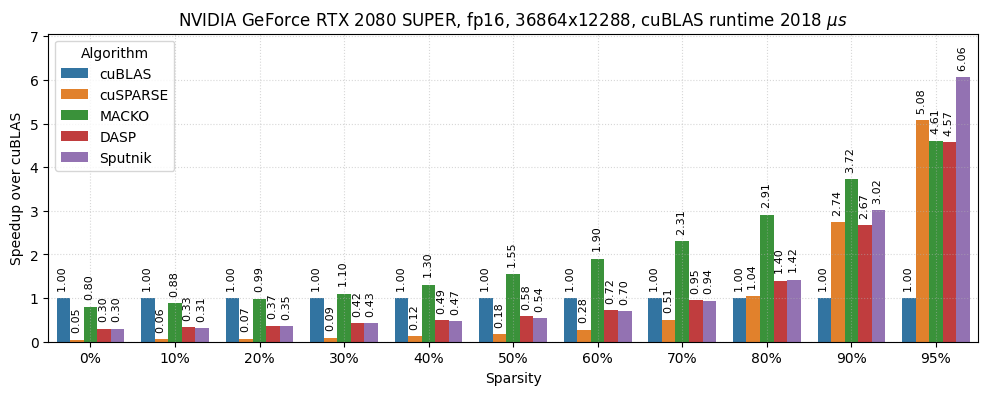

NVIDIA GeForce RTX 2080 SUPER, fp16, 12288x12288, cuBLAS runtime 708 $\mu s$


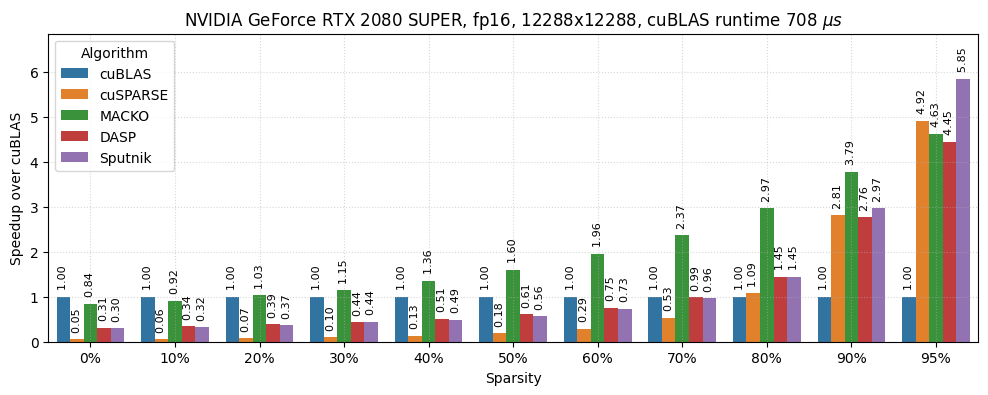

NVIDIA GeForce RTX 2080 SUPER, fp16, 49152x12288, cuBLAS runtime 2653 $\mu s$


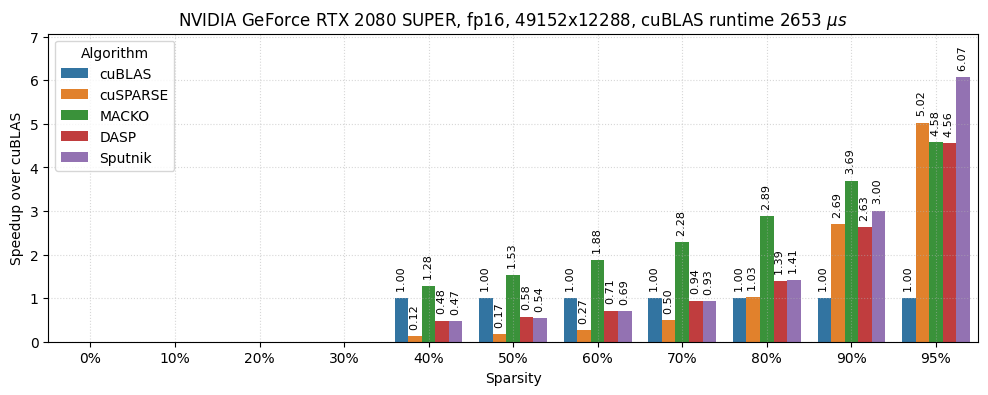

NVIDIA GeForce RTX 2080 SUPER, fp16, 12288x49152, cuBLAS runtime 2680 $\mu s$


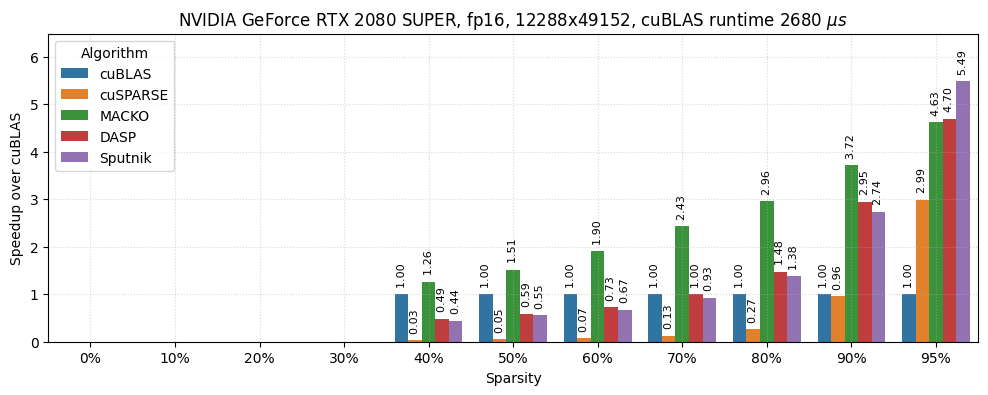

In [30]:
for target_gpu in gpus: 
    df = load_results(target_gpu)
    for shape in shapes:
        draw_speedup_bar(df, target_gpu, shape)

NVIDIA GeForce RTX 4090, fp16, 4096x4096, cuBLAS runtime 59 $\mu s$


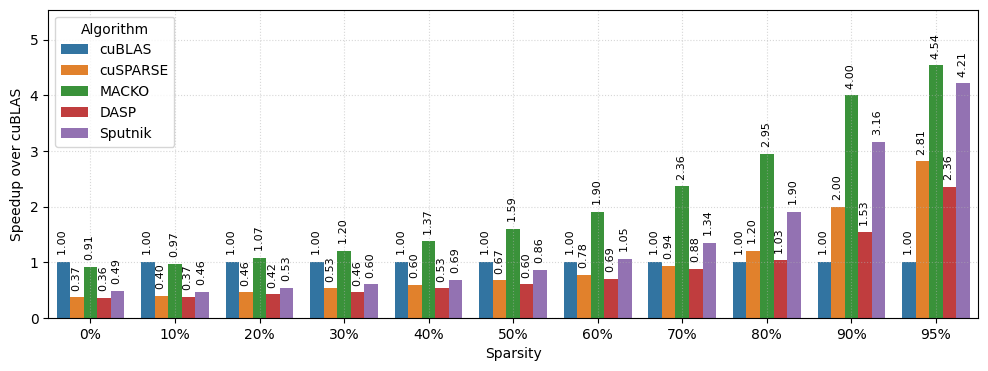

NVIDIA GeForce RTX 4090, fp16, 4096x11008, cuBLAS runtime 122 $\mu s$


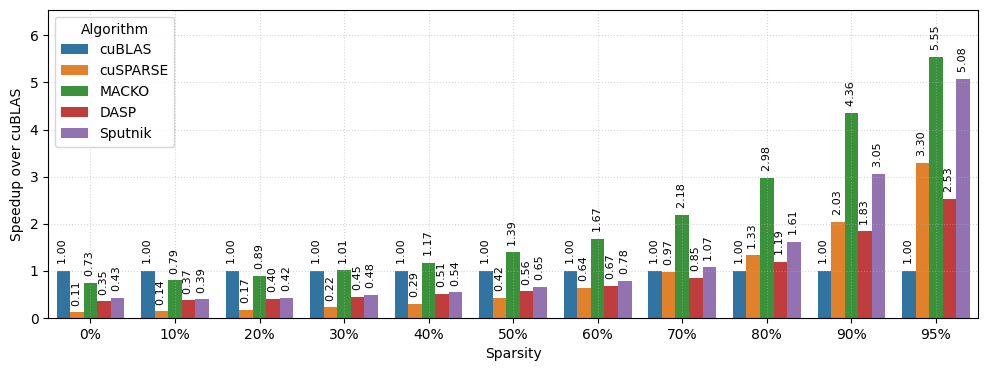

NVIDIA GeForce RTX 4090, fp16, 11008x4096, cuBLAS runtime 120 $\mu s$


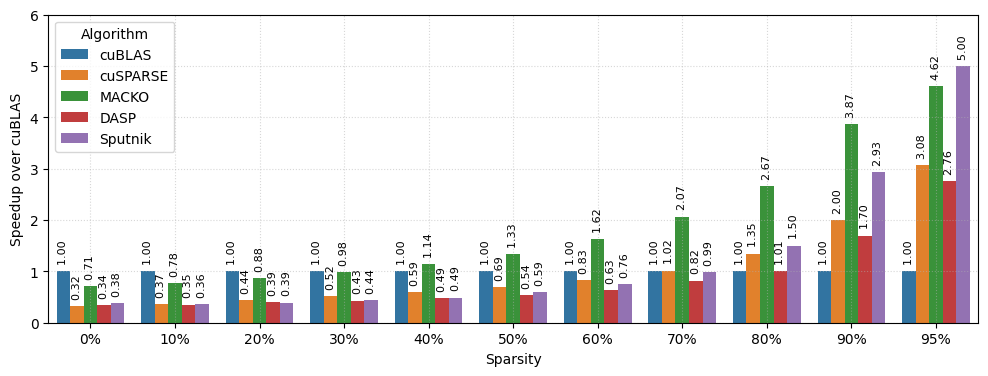

NVIDIA GeForce RTX 4090, fp16, 12288x12288, cuBLAS runtime 336 $\mu s$


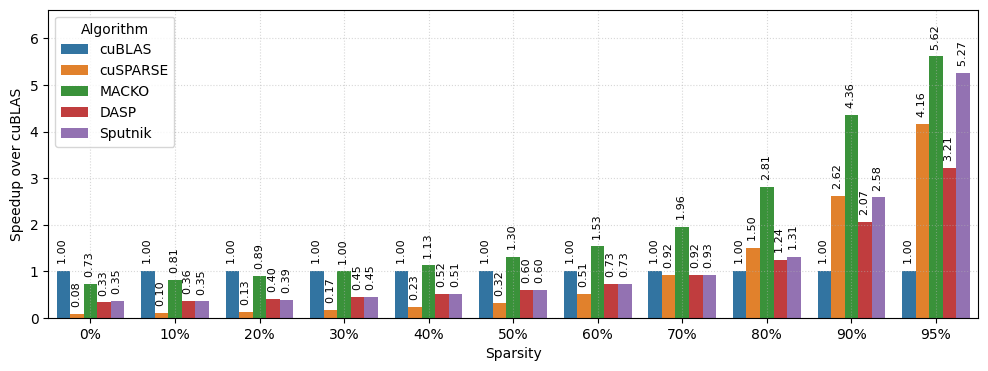

NVIDIA GeForce RTX 3090, fp16, 4096x4096, cuBLAS runtime 54 $\mu s$


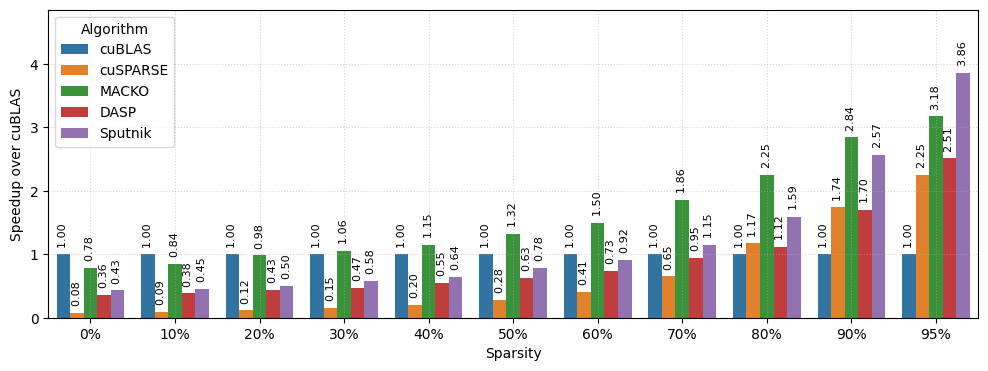

NVIDIA GeForce RTX 3090, fp16, 4096x11008, cuBLAS runtime 121 $\mu s$


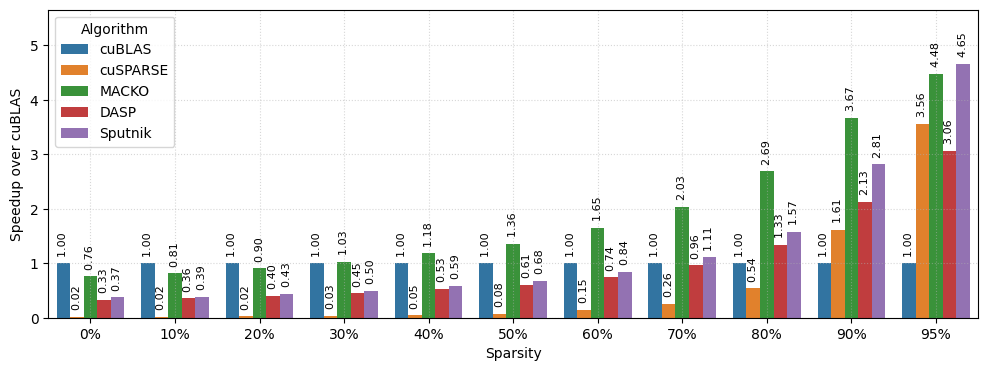

NVIDIA GeForce RTX 3090, fp16, 11008x4096, cuBLAS runtime 134 $\mu s$


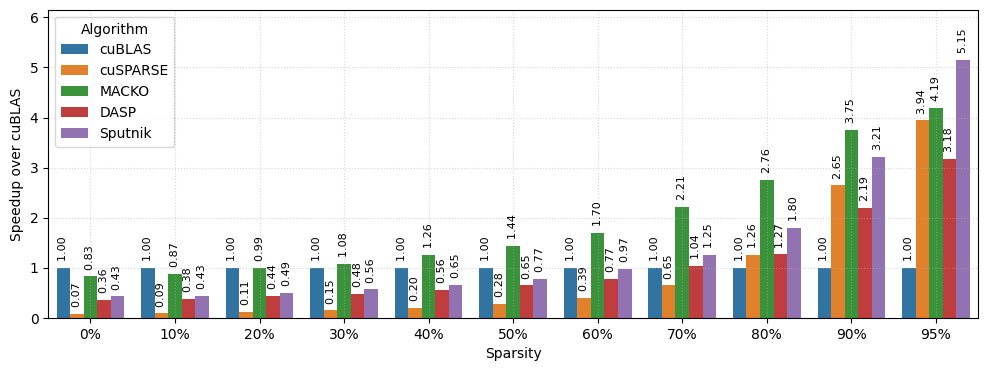

NVIDIA GeForce RTX 3090, fp16, 12288x12288, cuBLAS runtime 397 $\mu s$


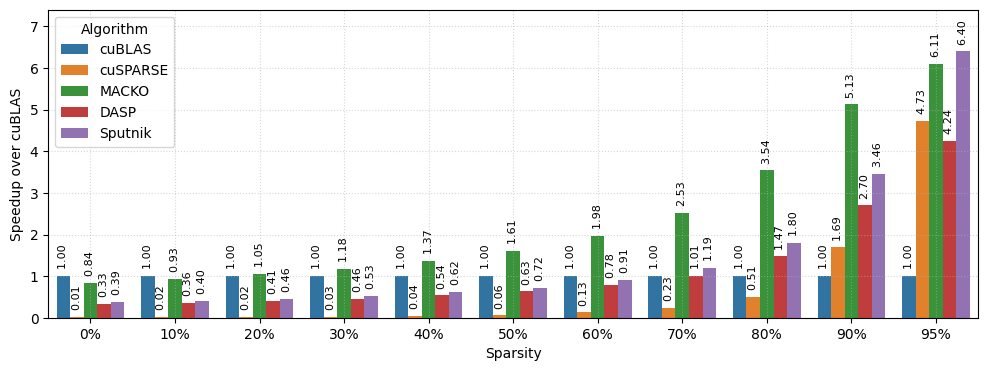

NVIDIA GeForce RTX 2080 SUPER, fp16, 4096x4096, cuBLAS runtime 86 $\mu s$


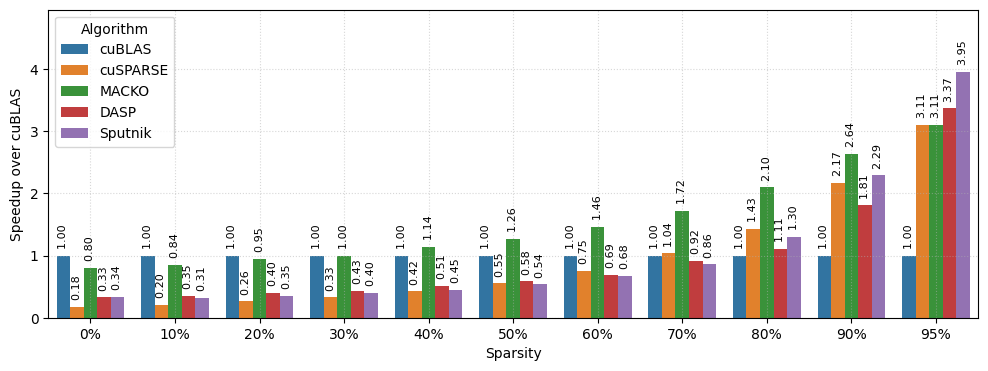

NVIDIA GeForce RTX 2080 SUPER, fp16, 4096x11008, cuBLAS runtime 223 $\mu s$


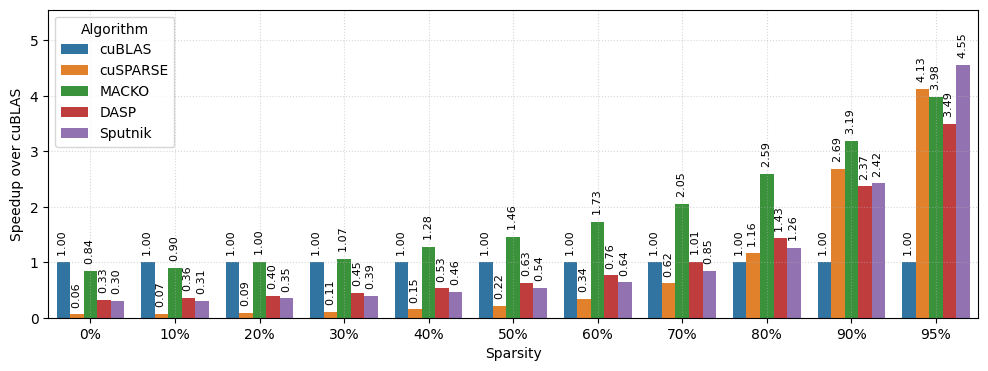

NVIDIA GeForce RTX 2080 SUPER, fp16, 11008x4096, cuBLAS runtime 211 $\mu s$


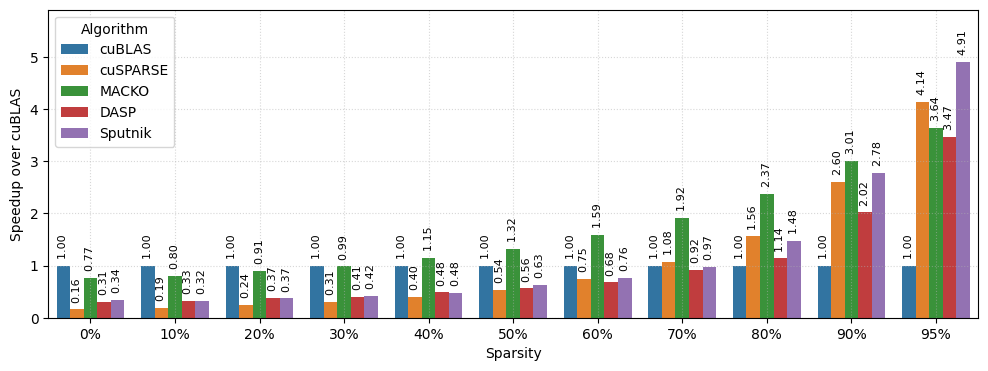

NVIDIA GeForce RTX 2080 SUPER, fp16, 12288x12288, cuBLAS runtime 708 $\mu s$


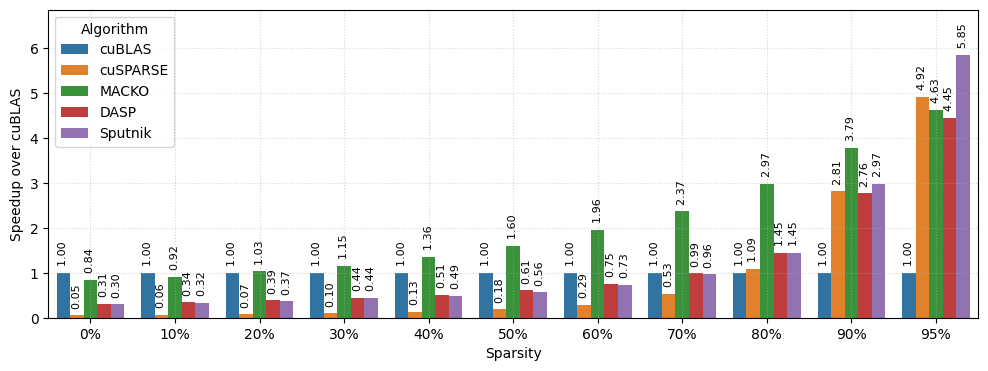

In [31]:
shapes = [
    [4096,4096],
    [4096,11008],
    [11008,4096],
    [12288,12288],
]
gpus = ["NVIDIA_GeForce_RTX_4090", "NVIDIA_GeForce_RTX_3090", "NVIDIA_GeForce_RTX_2080_SUPER"]
for target_gpu in gpus: 
    df = load_results(target_gpu)
    for shape in shapes:
        draw_speedup_bar(df, target_gpu, shape, to_paper=True)